In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
# Dynamic path setup
import sys
from pathlib import Path

# Find project root dynamically
current_dir = Path.cwd()
while current_dir.name != "ENEXIS" and current_dir.parent != current_dir:
    current_dir = current_dir.parent
project_root = current_dir

# Add utils to path
utils_path = project_root / "src" / "utils"
sys.path.append(str(utils_path))
from build_training_set import build_training_set
 
df = build_training_set(
    train_start="2025-01-01 00:00:00",
    train_end="2025-03-14 23:00:00",
    run_date="2025-03-15 00:00:00"
)

print(df.tail())
df.to_csv("training_set1.csv", index=False)


2025-05-30 14:35:15,834 - build_training_set - INFO - 📅 Loading additional historical data until 2025-03-15 00:00:00+00:00 for lagging support
2025-05-30 14:35:15,841 - build_training_set - INFO - 🚀 Start build van trainingset
2025-05-30 14:35:15,841 - build_training_set - INFO - 🧠 Actuals van 2025-01-01 00:00:00+00:00 t/m 2025-03-14 23:00:00+00:00 (extended to 2025-03-15 00:00:00+00:00 for lagging)
2025-05-30 14:35:15,841 - build_training_set - INFO - 📅 Forecast van run_date 2025-03-15 00:00:00+00:00, normalized to 2025-03-15 00:00:00+00:00 for DB lookup, target range: 2025-03-15 00:00:00+00:00 → 2025-03-22 00:00:00+00:00
2025-05-30 14:35:15,841 - build_training_set - INFO - 📥 Loading actuals with selected columns only...
2025-05-30 14:35:15,859 - build_training_set - INFO - 📋 Requested columns found: 20/20
2025-05-30 14:35:15,867 - build_training_set - INFO - 📋 Using columns: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'di

        Price           target_datetime      Load  shortwave_radiation  \
1916  0.06842 2025-03-21 20:00:00+00:00  15700.25                  0.0   
1917  0.04569 2025-03-21 21:00:00+00:00  14870.50                  0.0   
1918  0.02923 2025-03-21 22:00:00+00:00  14056.25                  0.0   
1919  0.02108 2025-03-21 23:00:00+00:00  13248.25                  0.0   
1920  0.02693 2025-03-22 00:00:00+00:00  12561.25                  0.0   

      temperature_2m  direct_normal_irradiance  diffuse_radiation  Flow_NO  \
1916           13.05                       0.0                0.0    621.0   
1917           13.00                       0.0                0.0    620.0   
1918           12.60                       0.0                0.0    621.0   
1919           12.00                       0.0                0.0    621.0   
1920           10.05                       0.0                0.0    621.0   

      yearday_cos  Flow_GB  month  is_dst  yearday_sin  is_non_working_day  \
1916    

In [2]:
from sklearn.ensemble import RandomForestRegressor

df['target_datetime'] = pd.to_datetime(df['target_datetime'], utc=True)
df['Timestamp'] = df['target_datetime']
# Feature engineering
df = df.dropna(subset=['target_datetime', 'Price'])

# Stel de periodes in
train_start = pd.Timestamp('2025-01-01', tz = 'UTC')
train_end = pd.Timestamp('2025-03-14 23:59:59', tz = 'UTC')
test_start = pd.Timestamp('2025-03-15', tz = 'UTC')
test_end = pd.Timestamp('2025-03-21 23:59:59', tz = 'UTC')

# Filter op basis van Timestamp
train = df[(df['Timestamp'] >= train_start) & (df['Timestamp'] <= train_end)]
test = df[(df['Timestamp'] >= test_start) & (df['Timestamp'] <= test_end)]

X_train = train[['weekday_sin', 'weekday_cos', 'hour_sin', 'hour_cos']]	
y_train = train['Price']
X_test = test[['weekday_sin', 'weekday_cos', 'hour_sin', 'hour_cos']]	
y_test = test['Price']

# Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluatie
from sklearn.metrics import mean_absolute_error
print("MAE:", mean_absolute_error(y_test, y_pred))

from sklearn.metrics import mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 0.03885165439220991
MAE: 0.03885165439220991
RMSE: 0.05183017036495341


In [3]:
from sklearn.ensemble import RandomForestRegressor

df['target_datetime'] = pd.to_datetime(df['target_datetime'], utc=True)
df['Timestamp'] = df['target_datetime']
# Feature engineering
df = df.dropna(subset=['target_datetime', 'Price'])

# Stel de periodes in
train_start = pd.Timestamp('2025-01-01', tz = 'UTC')
train_end = pd.Timestamp('2025-03-14 23:59:59', tz = 'UTC')
test_start = pd.Timestamp('2025-03-15', tz = 'UTC')
test_end = pd.Timestamp('2025-03-21 23:59:59', tz = 'UTC')

# Filter op basis van Timestamp
train = df[(df['Timestamp'] >= train_start) & (df['Timestamp'] <= train_end)]
test = df[(df['Timestamp'] >= test_start) & (df['Timestamp'] <= test_end)]

# Features voor het model
features = [
    'Flow_NO',  'hour_sin', 
    'Load','shortwave_radiation', 'temperature_2m', 
    'Flow_GB', 'weekday_sin'
] # excluded: 'month', 'yearday_sin', 'weekday_cos', diffuse_radiation', 'yearday_cos', 'hour_cos','is_dst','is_non_working_day', 'is_weekend','cloud_cover','direct_normal_irradiance',


X_train = train[features]
y_train = train['Price']
X_test = test[features]
y_test = test['Price']

# Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluatie
from sklearn.metrics import mean_absolute_error
print("MAE:", mean_absolute_error(y_test, y_pred))

from sklearn.metrics import mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 0.025593398809523826
MAE: 0.025593398809523826
RMSE: 0.03619868886563863


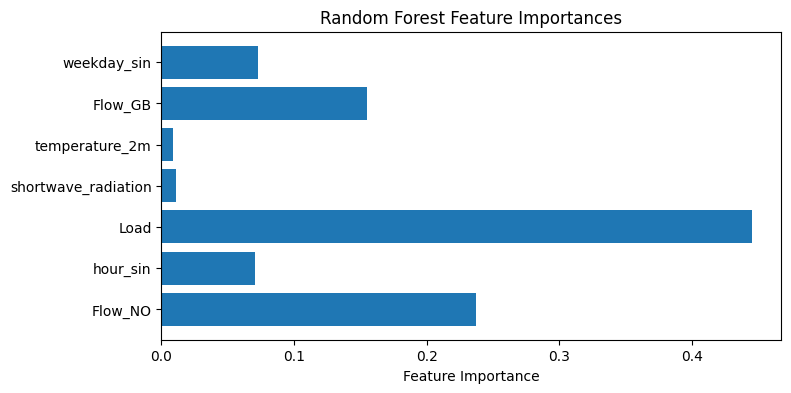

In [4]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
feature_names = X_train.columns

plt.figure(figsize=(8, 4))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.show()

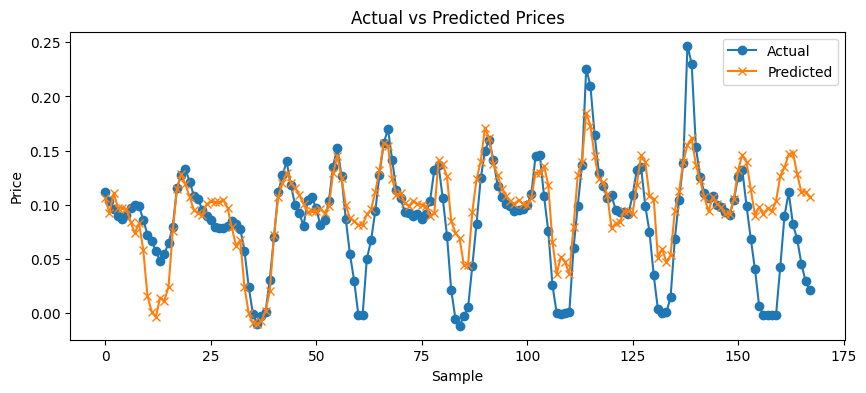

In [5]:
plt.figure(figsize=(10, 4))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.legend()
plt.title("Actual vs Predicted Prices")
plt.xlabel("Sample")
plt.ylabel("Price")
plt.show()

In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Define feature columns and target

FEATURES = ['weekday_cos', 'weekday_sin', 'hour_cos', 'hour_sin', 'yearday_cos', 'yearday_sin']
# excluded: : 'Flow_NO',  'hour_sin', 'Load',
#    'shortwave_radiation', 'temperature_2m', 'Flow_GB', 
 #   , 'Load', 'Flow_NO', 'Flow_GB', 'yearday_sin', 'diffuse_radiation', 'yearday_cos' 'hour_cos', 'month','is_dst',
# 'is_non_working_day', 'is_weekend','cloud_cover','direct_normal_irradiance',

TRAIN_FEATURES = FEATURES
TEST_FEATURES = FEATURES
target = 'Price'

# Initial training window
base_start = "2025-01-01 00:00:00"
base_end = "2025-03-14 23:00:00"
base_run = "2025-03-15 00:00:00"

rmse_results = []

print("🔍 Testing Random Forest Model - RMSE per forecast day")
print("=" * 60)

for i in range(30):
    start = pd.Timestamp(base_start)  + pd.Timedelta(days=i)
    end = pd.Timestamp(base_end) + pd.Timedelta(days=i)
    run_date = pd.Timestamp(base_run) + pd.Timedelta(days=i)

    try:
        df = build_training_set(
            train_start=start.strftime("%Y-%m-%d %H:%M:%S"),
            train_end=end.strftime("%Y-%m-%d %H:%M:%S"),
            run_date=run_date.strftime("%Y-%m-%d %H:%M:%S")
        )

        if df is None or df.empty:
            print(f"Day {i+1}: ❌ No training data returned")
            continue

        df['target_datetime'] = pd.to_datetime(df['target_datetime'], utc=True)
        df = df.sort_values('target_datetime').set_index('target_datetime')

        # Zorg dat run_date ook in UTC is
        run_date_utc = run_date.tz_localize("UTC")

        # Split into training and testing sets
        train_data = df[df.index <= run_date_utc]
        test_data = df[df.index > run_date_utc]

        # Drop any missing data in training
        train_data = train_data.dropna(subset=TRAIN_FEATURES + [target])

        if test_data.empty or train_data.empty:
            print(f"Day {i+1}: ❌ Not enough data for training or testing")
            continue

        # Train model
        X_train = train_data[TRAIN_FEATURES]
        y_train = train_data[target]

        # Aanvullen met NaN-kolommen waar nodig
        for col in TRAIN_FEATURES:
            if col not in test_data.columns:
                test_data[col] = np.nan

        X_test = test_data[TRAIN_FEATURES]
        y_test = test_data[target]




        X_test = test_data[TRAIN_FEATURES]
        y_test = test_data[target]

        # Sla de eerste 24 uur over
        X_test = X_test.iloc[24:]
        y_test = y_test.iloc[24:]

        # Alleen voorspellen als er nog testdata over is
        if len(X_test) > 0:
            y_pred = model.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            # ...rest van je evaluatie...
        else:
            print("Niet genoeg testdata na lag van 24 uur.")




        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_results.append({
            'iteration': i + 1,
            'run_date': run_date.strftime('%Y-%m-%d'),
            'valid_predictions': len(test_data),
            'rmse': rmse
        })

        print(f"Day {i+1}: ✅ {len(test_data)} test rows, Run: {run_date.strftime('%m-%d')}")

    except Exception as e:
        print(f"Day {i+1}: ❌ Error: {e}")

# Create results dataframe
if rmse_results:
    rmse_df = pd.DataFrame(rmse_results)

    print(f"\n📊 OVERALL RMSE - Random Forest Model")
    print("=" * 80)
    print(f"Successful runs: {len(rmse_df)}/30")

    print(rmse_df[['iteration', 'run_date', 'valid_predictions', 'rmse']].round(2).to_string(index=False))

    print(f"\n📈 SUMMARY STATISTICS")
    print("-" * 40)
    print(rmse_df['rmse'].describe().round(2))

    print(f"\n📊 AVERAGE OVERALL RMSE")
    print("-" * 40)
    print(f"Mean RMSE: {rmse_df['rmse'].mean():.4f}")
else:
    print("❌ No runs completed successfully")

2025-05-30 14:42:58,455 - build_training_set - INFO - 📅 Loading additional historical data until 2025-03-15 00:00:00+00:00 for lagging support
2025-05-30 14:42:58,455 - build_training_set - INFO - 🚀 Start build van trainingset
2025-05-30 14:42:58,455 - build_training_set - INFO - 🧠 Actuals van 2025-01-01 00:00:00+00:00 t/m 2025-03-14 23:00:00+00:00 (extended to 2025-03-15 00:00:00+00:00 for lagging)
2025-05-30 14:42:58,455 - build_training_set - INFO - 📅 Forecast van run_date 2025-03-15 00:00:00+00:00, normalized to 2025-03-15 00:00:00+00:00 for DB lookup, target range: 2025-03-15 00:00:00+00:00 → 2025-03-22 00:00:00+00:00
2025-05-30 14:42:58,466 - build_training_set - INFO - 📥 Loading actuals with selected columns only...


2025-05-30 14:42:58,474 - build_training_set - INFO - 📋 Requested columns found: 20/20
2025-05-30 14:42:58,474 - build_training_set - INFO - 📋 Using columns: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday_cos']
2025-05-30 14:42:58,565 - build_training_set - INFO - ✅ Actuals loaded: 1752 rows with 20 selected columns
2025-05-30 14:42:58,565 - build_training_set - INFO - 🔍 Loading forecast/prediction data...
2025-05-30 14:42:58,598 - build_training_set - INFO - 📊 Forecast rows available: 169
2025-05-30 14:42:58,598 - build_training_set - INFO - 📋 Common columns for predictions: 16 - ['target_datetime', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'yearday_cos', 'month', 'is_dst', 'yearday_sin', 'is

🔍 Testing Random Forest Model - RMSE per forecast day


2025-05-30 14:42:58,641 - build_training_set - INFO - 📊 Applying 168-hour lag for missing columns (excluding target variables)...
2025-05-30 14:42:58,641 - build_training_set - INFO -    🎯 Column 'Price' is target variable - filled with NaN (not lagged)
2025-05-30 14:42:58,641 - build_training_set - INFO -    🕐 Lagging column 'Load' by 168 hours
2025-05-30 14:42:58,765 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:42:58,765 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:42:58,838 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:42:58,838 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:42:58,932 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:42:58,932 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:42:58,940 - build_training_set - INFO - 💰 Retrieving actual prices fo

Day 1: ✅ 168 test rows, Run: 03-15


2025-05-30 14:42:59,973 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:42:59,982 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:43:00,130 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:43:00,130 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:43:00,227 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:43:00,227 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:43:00,235 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:43:00,243 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:43:00,316 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:43:00,316 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:43:00,316 - buil

Day 2: ✅ 168 test rows, Run: 03-16


2025-05-30 14:43:01,290 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:43:01,290 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:43:01,357 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:43:01,366 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:43:01,366 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:43:01,370 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:43:01,408 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:43:01,408 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:43:01,408 - build_training_set - INFO - ✅ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-30 14:43:01,418 - build_training_set - INFO - ✅ No overlap between actuals and predictions
202

Day 3: ✅ 168 test rows, Run: 03-17


2025-05-30 14:43:02,343 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:43:02,343 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:43:02,421 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:43:02,429 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:43:02,500 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:43:02,500 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:43:02,509 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:43:02,509 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:43:02,544 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:43:02,544 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:43:02,544 - buil

Day 4: ✅ 168 test rows, Run: 03-18


2025-05-30 14:43:03,589 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:43:03,589 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:43:03,695 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:43:03,695 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:43:03,780 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:43:03,780 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:43:03,780 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:43:03,788 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:43:03,847 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:43:03,857 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:43:03,857 - buil

Day 5: ✅ 168 test rows, Run: 03-19


2025-05-30 14:43:04,762 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:43:04,762 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:43:04,828 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:43:04,828 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:43:04,913 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:43:04,913 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:43:04,913 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:43:04,921 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:43:04,946 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:43:04,946 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:43:04,954 - buil

Day 6: ✅ 168 test rows, Run: 03-20


2025-05-30 14:43:05,979 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:43:05,986 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:43:06,118 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:43:06,118 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:43:06,236 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:43:06,244 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:43:06,255 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:43:06,261 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:43:06,304 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:43:06,304 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:43:06,304 - buil

Day 7: ✅ 168 test rows, Run: 03-21


2025-05-30 14:43:07,338 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:43:07,338 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:43:07,464 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:43:07,464 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:43:07,554 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:43:07,554 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:43:07,554 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:43:07,562 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:43:07,601 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:43:07,601 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:43:07,611 - buil

Day 8: ✅ 168 test rows, Run: 03-22


2025-05-30 14:43:08,750 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:43:08,757 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:43:08,810 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:43:08,818 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:43:08,818 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:43:08,822 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:43:08,872 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:43:08,872 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:43:08,880 - build_training_set - INFO - ✅ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-30 14:43:08,880 - build_training_set - INFO - ✅ No overlap between actuals and predictions
202

Day 9: ✅ 168 test rows, Run: 03-23


2025-05-30 14:43:09,874 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:43:09,874 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:43:09,991 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:43:09,991 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:43:09,991 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:43:09,999 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:43:10,065 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:43:10,065 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:43:10,074 - build_training_set - INFO - ✅ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-30 14:43:10,074 - build_training_set - INFO - ✅ No overlap between actuals and predictions
202

Day 10: ✅ 168 test rows, Run: 03-24


2025-05-30 14:43:10,978 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:43:10,978 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:43:11,145 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:43:11,145 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:43:11,237 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:43:11,241 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:43:11,241 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:43:11,249 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:43:11,317 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:43:11,317 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:43:11,325 - buil

Day 11: ✅ 168 test rows, Run: 03-25


2025-05-30 14:43:12,249 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:43:12,332 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:43:12,332 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:43:12,400 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:43:12,400 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:43:12,400 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:43:12,408 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:43:12,442 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:43:12,442 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:43:12,450 - build_training_set - INFO - ✅ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-

Day 12: ✅ 168 test rows, Run: 03-26


2025-05-30 14:43:13,293 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:43:13,418 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:43:13,427 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:43:13,497 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:43:13,505 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:43:13,505 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:43:13,508 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:43:13,546 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:43:13,554 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:43:13,558 - build_training_set - INFO - ✅ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-

Day 13: ✅ 168 test rows, Run: 03-27


2025-05-30 14:43:14,588 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:43:14,588 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:43:14,696 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:43:14,696 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:43:14,696 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:43:14,696 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:43:14,727 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:43:14,727 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:43:14,735 - build_training_set - INFO - ✅ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-30 14:43:14,735 - build_training_set - INFO - ✅ No overlap between actuals and predictions
202

Day 14: ✅ 168 test rows, Run: 03-28


2025-05-30 14:43:15,645 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:43:15,645 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:43:15,763 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:43:15,763 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:43:15,771 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:43:15,779 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:43:15,873 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:43:15,873 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:43:15,882 - build_training_set - INFO - ✅ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-30 14:43:15,882 - build_training_set - INFO - ✅ No overlap between actuals and predictions
202

Day 15: ✅ 168 test rows, Run: 03-29


2025-05-30 14:43:16,739 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:43:16,846 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:43:16,848 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:43:16,928 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:43:16,928 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:43:16,928 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:43:16,937 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:43:16,998 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:43:16,998 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:43:16,998 - build_training_set - INFO - ✅ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-

Day 16: ✅ 168 test rows, Run: 03-30


2025-05-30 14:43:17,808 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:43:17,905 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:43:17,906 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:43:17,980 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:43:17,980 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:43:17,980 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:43:17,980 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:43:18,036 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:43:18,045 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:43:18,047 - build_training_set - INFO - ✅ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-

Day 17: ✅ 168 test rows, Run: 03-31


2025-05-30 14:43:18,976 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:43:18,976 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:43:19,067 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:43:19,067 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:43:19,136 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:43:19,144 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:43:19,144 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:43:19,152 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:43:19,185 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:43:19,185 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:43:19,185 - buil

Day 18: ✅ 168 test rows, Run: 04-01


2025-05-30 14:43:20,124 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:43:20,192 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:43:20,192 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:43:20,264 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:43:20,264 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:43:20,272 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:43:20,274 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:43:20,315 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:43:20,315 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:43:20,323 - build_training_set - INFO - ✅ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-

Day 19: ✅ 168 test rows, Run: 04-02


2025-05-30 14:43:21,292 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:43:21,300 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:43:21,457 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:43:21,457 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:43:21,457 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:43:21,465 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:43:21,509 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:43:21,520 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:43:21,520 - build_training_set - INFO - ✅ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-30 14:43:21,528 - build_training_set - INFO - ✅ No overlap between actuals and predictions
202

Day 20: ✅ 168 test rows, Run: 04-03


2025-05-30 14:43:22,434 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:43:22,434 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:43:22,518 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:43:22,519 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:43:22,594 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:43:22,594 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:43:22,600 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:43:22,601 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:43:22,660 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:43:22,660 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:43:22,660 - buil

Day 21: ✅ 168 test rows, Run: 04-04


2025-05-30 14:43:23,451 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:43:23,537 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:43:23,537 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:43:23,612 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:43:23,612 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:43:23,612 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:43:23,620 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:43:23,668 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:43:23,668 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:43:23,668 - build_training_set - INFO - ✅ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-

Day 22: ✅ 168 test rows, Run: 04-05


2025-05-30 14:43:24,512 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:43:24,512 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:43:24,622 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:43:24,622 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:43:24,622 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:43:24,631 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:43:24,674 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:43:24,674 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:43:24,674 - build_training_set - INFO - ✅ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-30 14:43:24,674 - build_training_set - INFO - ✅ No overlap between actuals and predictions
202

Day 23: ✅ 168 test rows, Run: 04-06


2025-05-30 14:43:25,564 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:43:25,564 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:43:25,653 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:43:25,662 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:43:25,745 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:43:25,745 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:43:25,745 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:43:25,754 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:43:25,792 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:43:25,800 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:43:25,800 - buil

Day 24: ✅ 168 test rows, Run: 04-07


2025-05-30 14:43:26,823 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:43:26,823 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:43:26,896 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:43:26,906 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:43:26,907 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:43:26,907 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:43:26,958 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:43:26,958 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:43:26,958 - build_training_set - INFO - ✅ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-30 14:43:26,966 - build_training_set - INFO - ✅ No overlap between actuals and predictions
202

Day 25: ✅ 168 test rows, Run: 04-08


2025-05-30 14:43:27,811 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:43:27,811 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:43:27,975 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:43:27,975 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:43:28,064 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:43:28,072 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:43:28,072 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:43:28,080 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:43:28,140 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:43:28,140 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:43:28,140 - buil

Day 26: ✅ 168 test rows, Run: 04-09


2025-05-30 14:43:28,988 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:43:28,988 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:43:29,066 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:43:29,066 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:43:29,139 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:43:29,139 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:43:29,139 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:43:29,147 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:43:29,199 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:43:29,208 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:43:29,208 - buil

Day 27: ✅ 168 test rows, Run: 04-10


2025-05-30 14:43:29,995 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:43:30,003 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:43:30,082 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:43:30,082 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:43:30,140 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:43:30,140 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:43:30,140 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:43:30,148 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:43:30,181 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:43:30,189 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:43:30,189 - buil

Day 28: ✅ 168 test rows, Run: 04-11


2025-05-30 14:43:30,991 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:43:30,991 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:43:31,125 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:43:31,125 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:43:31,216 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:43:31,216 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:43:31,216 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:43:31,224 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:43:31,264 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:43:31,264 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:43:31,274 - buil

Day 29: ✅ 168 test rows, Run: 04-12


2025-05-30 14:43:32,326 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:43:32,326 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:43:32,450 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:43:32,450 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:43:32,458 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:43:32,466 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:43:32,518 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:43:32,518 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:43:32,526 - build_training_set - INFO - ✅ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-30 14:43:32,526 - build_training_set - INFO - ✅ No overlap between actuals and predictions
202

Day 30: ✅ 168 test rows, Run: 04-13

📊 OVERALL RMSE - Random Forest Model
Successful runs: 30/30
 iteration   run_date  valid_predictions  rmse
         1 2025-03-15                168  0.05
         2 2025-03-16                168  0.05
         3 2025-03-17                168  0.03
         4 2025-03-18                168  0.04
         5 2025-03-19                168  0.04
         6 2025-03-20                168  0.04
         7 2025-03-21                168  0.04
         8 2025-03-22                168  0.04
         9 2025-03-23                168  0.06
        10 2025-03-24                168  0.05
        11 2025-03-25                168  0.05
        12 2025-03-26                168  0.05
        13 2025-03-27                168  0.06
        14 2025-03-28                168  0.05
        15 2025-03-29                168  0.04
        16 2025-03-30                168  0.04
        17 2025-03-31                168  0.05
        18 2025-04-01                168  0.03
        19

In [10]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Define feature columns and target

FEATURES = ['weekday_cos', 'weekday_sin', 'hour_cos', 'hour_sin', 
            'yearday_cos', 'yearday_sin', 'Flow_NO', 'Load', 'shortwave_radiation', 
            'temperature_2m', 'Flow_GB', 
            'diffuse_radiation', 'month','is_dst',
            'is_non_working_day', 'is_weekend','cloud_cover','direct_normal_irradiance']

TRAIN_FEATURES = FEATURES
TEST_FEATURES = FEATURES
target = 'Price'

# Initial training window
base_start = "2025-01-01 00:00:00"
base_end = "2025-03-14 23:00:00"
base_run = "2025-03-15 00:00:00"

rmse_results = []

print("🔍 Testing Random Forest Model - RMSE per forecast day")
print("=" * 60)

for i in range(30):
    start = pd.Timestamp(base_start)  + pd.Timedelta(days=i)
    end = pd.Timestamp(base_end) + pd.Timedelta(days=i)
    run_date = pd.Timestamp(base_run) + pd.Timedelta(days=i)

    try:
        df = build_training_set(
            train_start=start.strftime("%Y-%m-%d %H:%M:%S"),
            train_end=end.strftime("%Y-%m-%d %H:%M:%S"),
            run_date=run_date.strftime("%Y-%m-%d %H:%M:%S")
        )

        if df is None or df.empty:
            print(f"Day {i+1}: ❌ No training data returned")
            continue

        df['target_datetime'] = pd.to_datetime(df['target_datetime'], utc=True)
        df = df.sort_values('target_datetime').set_index('target_datetime')

        # Zorg dat run_date ook in UTC is
        run_date_utc = run_date.tz_localize("UTC")

        # Split into training and testing sets
        train_data = df[df.index <= run_date_utc]
        test_data = df[df.index > run_date_utc]

        # Drop any missing data in training
        train_data = train_data.dropna(subset=TRAIN_FEATURES + [target])

        if test_data.empty or train_data.empty:
            print(f"Day {i+1}: ❌ Not enough data for training or testing")
            continue

        # Train model
        X_train = train_data[TRAIN_FEATURES]
        y_train = train_data[target]

        # Aanvullen met NaN-kolommen waar nodig
        for col in TRAIN_FEATURES:
            if col not in test_data.columns:
                test_data[col] = np.nan

        X_test = test_data[TRAIN_FEATURES]
        y_test = test_data[target]




        X_test = test_data[TRAIN_FEATURES]
        y_test = test_data[target]

        # Sla de eerste 24 uur over
        X_test = X_test.iloc[24:]
        y_test = y_test.iloc[24:]

        # Alleen voorspellen als er nog testdata over is
        if len(X_test) > 0:
            y_pred = model.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            # ...rest van je evaluatie...
        else:
            print("Niet genoeg testdata na lag van 24 uur.")




        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_results.append({
            'iteration': i + 1,
            'run_date': run_date.strftime('%Y-%m-%d'),
            'valid_predictions': len(test_data),
            'rmse': rmse
        })

        print(f"Day {i+1}: ✅ {len(test_data)} test rows, Run: {run_date.strftime('%m-%d')}")

    except Exception as e:
        print(f"Day {i+1}: ❌ Error: {e}")

# Create results dataframe
if rmse_results:
    rmse_df = pd.DataFrame(rmse_results)

    print(f"\n📊 OVERALL RMSE - Random Forest Model")
    print("=" * 80)
    print(f"Successful runs: {len(rmse_df)}/30")

    print(rmse_df[['iteration', 'run_date', 'valid_predictions', 'rmse']].round(2).to_string(index=False))

    print(f"\n📈 SUMMARY STATISTICS")
    print("-" * 40)
    print(rmse_df['rmse'].describe().round(2))

    print(f"\n📊 AVERAGE OVERALL RMSE")
    print("-" * 40)
    print(f"Mean RMSE: {rmse_df['rmse'].mean():.4f}")
else:
    print("❌ No runs completed successfully")

2025-05-30 14:58:28,755 - build_training_set - INFO - 📅 Loading additional historical data until 2025-03-15 00:00:00+00:00 for lagging support
2025-05-30 14:58:28,764 - build_training_set - INFO - 🚀 Start build van trainingset
2025-05-30 14:58:28,765 - build_training_set - INFO - 🧠 Actuals van 2025-01-01 00:00:00+00:00 t/m 2025-03-14 23:00:00+00:00 (extended to 2025-03-15 00:00:00+00:00 for lagging)
2025-05-30 14:58:28,765 - build_training_set - INFO - 📅 Forecast van run_date 2025-03-15 00:00:00+00:00, normalized to 2025-03-15 00:00:00+00:00 for DB lookup, target range: 2025-03-15 00:00:00+00:00 → 2025-03-22 00:00:00+00:00
2025-05-30 14:58:28,765 - build_training_set - INFO - 📥 Loading actuals with selected columns only...
2025-05-30 14:58:28,785 - build_training_set - INFO - 📋 Requested columns found: 20/20
2025-05-30 14:58:28,785 - build_training_set - INFO - 📋 Using columns: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'di

🔍 Testing Random Forest Model - RMSE per forecast day


2025-05-30 14:58:28,941 - build_training_set - INFO - 📋 Common columns for predictions: 16 - ['target_datetime', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'yearday_cos', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday_cos']
2025-05-30 14:58:28,983 - build_training_set - INFO - ✅ Predictions loaded: 169 rows with 16 columns
2025-05-30 14:58:28,984 - build_training_set - INFO - 🔧 Missing columns in predictions: ['Price', 'Load', 'Flow_NO', 'Flow_GB']
2025-05-30 14:58:28,984 - build_training_set - INFO - 📊 Applying 168-hour lag for missing columns (excluding target variables)...
2025-05-30 14:58:28,984 - build_training_set - INFO -    🎯 Column 'Price' is target variable - filled with NaN (not lagged)
2025-05-30 14:58:28,992 - build_training_set - INFO -    🕐 Lagging column 'Load' by 168 hours
2025-05-30 14:58:29,151 - build_training_set - INFO -    ✅ Added L

Day 1: ❌ Error: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Flow_GB
- Flow_NO
- Load
- cloud_cover
- diffuse_radiation
- ...



2025-05-30 14:58:29,991 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:58:29,991 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:58:30,145 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:58:30,145 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:58:30,277 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:58:30,277 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:58:30,277 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:58:30,286 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:58:30,346 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:58:30,356 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:58:30,356 - buil

Day 2: ❌ Error: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Flow_GB
- Flow_NO
- Load
- cloud_cover
- diffuse_radiation
- ...



2025-05-30 14:58:30,743 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:58:30,743 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:58:30,843 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:58:30,843 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:58:30,919 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:58:30,922 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:58:30,923 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:58:30,927 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:58:30,965 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:58:30,965 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:58:30,973 - buil

Day 3: ❌ Error: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Flow_GB
- Flow_NO
- Load
- cloud_cover
- diffuse_radiation
- ...



2025-05-30 14:58:31,385 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:58:31,386 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:58:31,534 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:58:31,534 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:58:31,608 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:58:31,608 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:58:31,608 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:58:31,619 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:58:31,652 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:58:31,652 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:58:31,652 - buil

Day 4: ❌ Error: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Flow_GB
- Flow_NO
- Load
- cloud_cover
- diffuse_radiation
- ...



2025-05-30 14:58:31,953 - build_training_set - INFO -    🕐 Lagging column 'Load' by 168 hours
2025-05-30 14:58:32,082 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:58:32,082 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:58:32,169 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:58:32,169 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:58:32,260 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:58:32,269 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:58:32,269 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:58:32,269 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:58:32,327 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:58:32,327 -

Day 5: ❌ Error: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Flow_GB
- Flow_NO
- Load
- cloud_cover
- diffuse_radiation
- ...



2025-05-30 14:58:32,655 - build_training_set - INFO - 🔧 Missing columns in predictions: ['Price', 'Load', 'Flow_NO', 'Flow_GB']
2025-05-30 14:58:32,655 - build_training_set - INFO - 📊 Applying 168-hour lag for missing columns (excluding target variables)...
2025-05-30 14:58:32,655 - build_training_set - INFO -    🎯 Column 'Price' is target variable - filled with NaN (not lagged)
2025-05-30 14:58:32,655 - build_training_set - INFO -    🕐 Lagging column 'Load' by 168 hours
2025-05-30 14:58:32,807 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:58:32,807 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:58:32,963 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:58:32,963 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:58:33,046 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:58:33,055 - build_training_set - I

Day 6: ❌ Error: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Flow_GB
- Flow_NO
- Load
- cloud_cover
- diffuse_radiation
- ...



2025-05-30 14:58:33,464 - build_training_set - INFO - 🔧 Missing columns in predictions: ['Price', 'Load', 'Flow_NO', 'Flow_GB']
2025-05-30 14:58:33,464 - build_training_set - INFO - 📊 Applying 168-hour lag for missing columns (excluding target variables)...
2025-05-30 14:58:33,472 - build_training_set - INFO -    🎯 Column 'Price' is target variable - filled with NaN (not lagged)
2025-05-30 14:58:33,472 - build_training_set - INFO -    🕐 Lagging column 'Load' by 168 hours
2025-05-30 14:58:33,594 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:58:33,603 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:58:33,708 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:58:33,708 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:58:33,789 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:58:33,789 - build_training_set - I

Day 7: ❌ Error: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Flow_GB
- Flow_NO
- Load
- cloud_cover
- diffuse_radiation
- ...



2025-05-30 14:58:34,247 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:58:34,247 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:58:34,365 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:58:34,365 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:58:34,481 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:58:34,481 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:58:34,481 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:58:34,490 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:58:34,555 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:58:34,558 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:58:34,558 - buil

Day 8: ❌ Error: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Flow_GB
- Flow_NO
- Load
- cloud_cover
- diffuse_radiation
- ...



2025-05-30 14:58:34,893 - build_training_set - INFO - 🔧 Missing columns in predictions: ['Price', 'Load', 'Flow_NO', 'Flow_GB']
2025-05-30 14:58:34,893 - build_training_set - INFO - 📊 Applying 168-hour lag for missing columns (excluding target variables)...
2025-05-30 14:58:34,903 - build_training_set - INFO -    🎯 Column 'Price' is target variable - filled with NaN (not lagged)
2025-05-30 14:58:34,903 - build_training_set - INFO -    🕐 Lagging column 'Load' by 168 hours
2025-05-30 14:58:35,031 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:58:35,031 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:58:35,148 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:58:35,148 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:58:35,288 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:58:35,288 - build_training_set - I

Day 9: ❌ Error: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Flow_GB
- Flow_NO
- Load
- cloud_cover
- diffuse_radiation
- ...



2025-05-30 14:58:35,687 - build_training_set - INFO - 🔧 Missing columns in predictions: ['Price', 'Load', 'Flow_NO', 'Flow_GB']
2025-05-30 14:58:35,687 - build_training_set - INFO - 📊 Applying 168-hour lag for missing columns (excluding target variables)...
2025-05-30 14:58:35,687 - build_training_set - INFO -    🎯 Column 'Price' is target variable - filled with NaN (not lagged)
2025-05-30 14:58:35,687 - build_training_set - INFO -    🕐 Lagging column 'Load' by 168 hours
2025-05-30 14:58:35,856 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:58:35,856 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:58:35,937 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:58:35,937 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:58:36,039 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:58:36,039 - build_training_set - I

Day 10: ❌ Error: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Flow_GB
- Flow_NO
- Load
- cloud_cover
- diffuse_radiation
- ...



2025-05-30 14:58:36,447 - build_training_set - INFO -    🕐 Lagging column 'Load' by 168 hours
2025-05-30 14:58:36,606 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:58:36,606 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:58:36,706 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:58:36,706 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:58:36,779 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:58:36,787 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:58:36,790 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:58:36,790 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:58:36,843 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:58:36,843 -

Day 11: ❌ Error: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Flow_GB
- Flow_NO
- Load
- cloud_cover
- diffuse_radiation
- ...



2025-05-30 14:58:37,161 - build_training_set - INFO - 🔧 Missing columns in predictions: ['Price', 'Load', 'Flow_NO', 'Flow_GB']
2025-05-30 14:58:37,161 - build_training_set - INFO - 📊 Applying 168-hour lag for missing columns (excluding target variables)...
2025-05-30 14:58:37,170 - build_training_set - INFO -    🎯 Column 'Price' is target variable - filled with NaN (not lagged)
2025-05-30 14:58:37,170 - build_training_set - INFO -    🕐 Lagging column 'Load' by 168 hours
2025-05-30 14:58:37,325 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:58:37,333 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:58:37,449 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:58:37,449 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:58:37,523 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:58:37,531 - build_training_set - I

Day 12: ❌ Error: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Flow_GB
- Flow_NO
- Load
- cloud_cover
- diffuse_radiation
- ...



2025-05-30 14:58:38,041 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:58:38,049 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:58:38,192 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:58:38,192 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:58:38,311 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:58:38,311 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:58:38,319 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:58:38,323 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:58:38,365 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:58:38,369 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:58:38,372 - buil

Day 13: ❌ Error: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Flow_GB
- Flow_NO
- Load
- cloud_cover
- diffuse_radiation
- ...



2025-05-30 14:58:38,658 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:58:38,658 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:58:38,743 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:58:38,755 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:58:38,865 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:58:38,865 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:58:38,865 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:58:38,873 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:58:38,935 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:58:38,944 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:58:38,944 - buil

Day 14: ❌ Error: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Flow_GB
- Flow_NO
- Load
- cloud_cover
- diffuse_radiation
- ...



2025-05-30 14:58:39,278 - build_training_set - INFO -    🕐 Lagging column 'Load' by 168 hours
2025-05-30 14:58:39,441 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:58:39,441 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:58:39,573 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:58:39,573 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:58:39,703 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:58:39,703 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:58:39,703 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:58:39,713 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:58:39,765 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:58:39,765 -

Day 15: ❌ Error: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Flow_GB
- Flow_NO
- Load
- cloud_cover
- diffuse_radiation
- ...



2025-05-30 14:58:40,108 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:58:40,108 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:58:40,193 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:58:40,193 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:58:40,284 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:58:40,284 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:58:40,284 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:58:40,292 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:58:40,360 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:58:40,368 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:58:40,368 - buil

Day 16: ❌ Error: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Flow_GB
- Flow_NO
- Load
- cloud_cover
- diffuse_radiation
- ...



2025-05-30 14:58:40,793 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:58:40,793 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:58:40,896 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:58:40,896 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:58:40,964 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:58:40,964 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:58:40,964 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:58:40,972 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:58:41,024 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:58:41,024 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:58:41,028 - buil

Day 17: ❌ Error: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Flow_GB
- Flow_NO
- Load
- cloud_cover
- diffuse_radiation
- ...



2025-05-30 14:58:41,336 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:58:41,345 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:58:41,436 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:58:41,438 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:58:41,520 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:58:41,520 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:58:41,520 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:58:41,528 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:58:41,583 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:58:41,583 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:58:41,585 - buil

Day 18: ❌ Error: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Flow_GB
- Flow_NO
- Load
- cloud_cover
- diffuse_radiation
- ...



2025-05-30 14:58:41,943 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:58:41,943 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:58:42,052 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:58:42,060 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:58:42,161 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:58:42,161 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:58:42,161 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:58:42,181 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:58:42,237 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:58:42,242 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:58:42,246 - buil

Day 19: ❌ Error: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Flow_GB
- Flow_NO
- Load
- cloud_cover
- diffuse_radiation
- ...



2025-05-30 14:58:42,570 - build_training_set - INFO - 🔧 Missing columns in predictions: ['Price', 'Load', 'Flow_NO', 'Flow_GB']
2025-05-30 14:58:42,570 - build_training_set - INFO - 📊 Applying 168-hour lag for missing columns (excluding target variables)...
2025-05-30 14:58:42,580 - build_training_set - INFO -    🎯 Column 'Price' is target variable - filled with NaN (not lagged)
2025-05-30 14:58:42,580 - build_training_set - INFO -    🕐 Lagging column 'Load' by 168 hours
2025-05-30 14:58:42,711 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:58:42,711 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:58:42,837 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:58:42,837 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:58:42,961 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:58:42,961 - build_training_set - I

Day 20: ❌ Error: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Flow_GB
- Flow_NO
- Load
- cloud_cover
- diffuse_radiation
- ...



2025-05-30 14:58:43,487 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:58:43,495 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:58:43,612 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:58:43,612 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:58:43,712 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:58:43,712 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:58:43,712 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:58:43,722 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:58:43,770 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:58:43,770 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:58:43,770 - buil

Day 21: ❌ Error: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Flow_GB
- Flow_NO
- Load
- cloud_cover
- diffuse_radiation
- ...



2025-05-30 14:58:44,063 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:58:44,063 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:58:44,206 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:58:44,206 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:58:44,271 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:58:44,279 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:58:44,281 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:58:44,281 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:58:44,327 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:58:44,330 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:58:44,330 - buil

Day 22: ❌ Error: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Flow_GB
- Flow_NO
- Load
- cloud_cover
- diffuse_radiation
- ...



2025-05-30 14:58:44,620 - build_training_set - INFO - 📊 Applying 168-hour lag for missing columns (excluding target variables)...
2025-05-30 14:58:44,620 - build_training_set - INFO -    🎯 Column 'Price' is target variable - filled with NaN (not lagged)
2025-05-30 14:58:44,629 - build_training_set - INFO -    🕐 Lagging column 'Load' by 168 hours
2025-05-30 14:58:44,726 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:58:44,734 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:58:44,783 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:58:44,792 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:58:44,880 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:58:44,889 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:58:44,889 - build_training_set - INFO - 💰 Retrieving actual prices fo

Day 23: ❌ Error: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Flow_GB
- Flow_NO
- Load
- cloud_cover
- diffuse_radiation
- ...



2025-05-30 14:58:45,256 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:58:45,256 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:58:45,407 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:58:45,407 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:58:45,522 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:58:45,522 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:58:45,522 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:58:45,532 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:58:45,574 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:58:45,574 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:58:45,574 - buil

Day 24: ❌ Error: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Flow_GB
- Flow_NO
- Load
- cloud_cover
- diffuse_radiation
- ...



2025-05-30 14:58:45,916 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:58:45,924 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:58:46,003 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:58:46,003 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:58:46,080 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:58:46,089 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:58:46,089 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:58:46,089 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:58:46,128 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:58:46,128 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:58:46,136 - buil

Day 25: ❌ Error: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Flow_GB
- Flow_NO
- Load
- cloud_cover
- diffuse_radiation
- ...



2025-05-30 14:58:46,498 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:58:46,498 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:58:46,658 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:58:46,658 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:58:46,743 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:58:46,743 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:58:46,751 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:58:46,753 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:58:46,828 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:58:46,829 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:58:46,829 - buil

Day 26: ❌ Error: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Flow_GB
- Flow_NO
- Load
- cloud_cover
- diffuse_radiation
- ...



2025-05-30 14:58:47,157 - build_training_set - INFO - 🔧 Missing columns in predictions: ['Price', 'Load', 'Flow_NO', 'Flow_GB']
2025-05-30 14:58:47,157 - build_training_set - INFO - 📊 Applying 168-hour lag for missing columns (excluding target variables)...
2025-05-30 14:58:47,166 - build_training_set - INFO -    🎯 Column 'Price' is target variable - filled with NaN (not lagged)
2025-05-30 14:58:47,166 - build_training_set - INFO -    🕐 Lagging column 'Load' by 168 hours
2025-05-30 14:58:47,267 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:58:47,267 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:58:47,381 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:58:47,389 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:58:47,465 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:58:47,473 - build_training_set - I

Day 27: ❌ Error: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Flow_GB
- Flow_NO
- Load
- cloud_cover
- diffuse_radiation
- ...



2025-05-30 14:58:47,922 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:58:47,931 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:58:48,025 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:58:48,026 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:58:48,094 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:58:48,094 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:58:48,094 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:58:48,102 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:58:48,130 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:58:48,136 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:58:48,136 - buil

Day 28: ❌ Error: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Flow_GB
- Flow_NO
- Load
- cloud_cover
- diffuse_radiation
- ...



2025-05-30 14:58:48,517 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:58:48,525 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:58:48,644 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:58:48,644 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:58:48,727 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:58:48,727 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:58:48,727 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:58:48,735 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:58:48,786 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:58:48,787 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:58:48,787 - buil

Day 29: ❌ Error: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Flow_GB
- Flow_NO
- Load
- cloud_cover
- diffuse_radiation
- ...



2025-05-30 14:58:49,209 - build_training_set - INFO -    ✅ Added Load: 169/169 values found
2025-05-30 14:58:49,218 - build_training_set - INFO -    🕐 Lagging column 'Flow_NO' by 168 hours
2025-05-30 14:58:49,317 - build_training_set - INFO -    ✅ Added Flow_NO: 169/169 values found
2025-05-30 14:58:49,326 - build_training_set - INFO -    🕐 Lagging column 'Flow_GB' by 168 hours
2025-05-30 14:58:49,435 - build_training_set - INFO -    ✅ Added Flow_GB: 169/169 values found
2025-05-30 14:58:49,435 - build_training_set - INFO - 🔄 Combining actuals and predictions...
2025-05-30 14:58:49,435 - build_training_set - INFO - 💰 Retrieving actual prices for forecast period...
2025-05-30 14:58:49,443 - build_training_set - INFO - 📊 Found 169 actual prices for forecast period
2025-05-30 14:58:49,502 - build_training_set - INFO - ✅ Filled 169/169 prediction prices with actual values
2025-05-30 14:58:49,502 - build_training_set - INFO - 💰 Price coverage: 169/169 (100.0%)
2025-05-30 14:58:49,510 - buil

Day 30: ❌ Error: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Flow_GB
- Flow_NO
- Load
- cloud_cover
- diffuse_radiation
- ...

❌ No runs completed successfully


In [164]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# Example: Use your initial training set to select features
df = build_training_set(
    train_start="2025-01-01 00:00:00",
    train_end="2025-03-14 23:00:00",
    run_date="2025-03-15 00:00:00"
)
df['target_datetime'] = pd.to_datetime(df['target_datetime'], utc=True)
df = df.sort_values('target_datetime').set_index('target_datetime')

# Define all candidate features
ALL_FEATURES = [
    'is_dst', 'hour_cos', 'hour_sin', 'month', 'is_non_working_day',
    'shortwave_radiation', 'temperature_2m', 'cloud_cover', 'direct_normal_irradiance',
    'diffuse_radiation', 'is_weekend', 'yearday_cos', 'yearday_sin',
    'weekday_sin', 'weekday_cos', 'Load', 'Flow_NO', 'Flow_GB'
]
target = 'Price'

# Drop missing values
df = df.dropna(subset=ALL_FEATURES + [target])

# Train a Random Forest to get feature importances
X = df[ALL_FEATURES]
y = df[target]
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

importances = model.feature_importances_
feat_imp_df = pd.DataFrame({
    'Feature': ALL_FEATURES,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print top N features
N = 10
print(f"Top {N} features by importance:")
print(feat_imp_df.head(N))

# If you want to use the top N features for your model:
SELECTED_FEATURES = feat_imp_df['Feature'].head(N).tolist()
print("Selected features for the model:", SELECTED_FEATURES)

2025-05-30 08:20:01,844 - build_training_set - INFO - 🚀 Start build van trainingset
2025-05-30 08:20:01,848 - build_training_set - INFO - 🧠 Actuals van 2025-01-01 00:00:00+00:00 t/m 2025-03-14 23:00:00+00:00
2025-05-30 08:20:01,850 - build_training_set - INFO - 📅 Forecast van run_date 2025-03-15 00:00:00+00:00, target range: 2025-03-15 00:00:00+00:00 → 2025-03-21 23:00:00+00:00
2025-05-30 08:20:01,996 - build_training_set - INFO - ✅ Actuals geladen: 1752 rijen
2025-05-30 08:20:02,487 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=

Top 10 features by importance:
                     Feature  Importance
15                      Load    0.383626
16                   Flow_NO    0.201825
17                   Flow_GB    0.088859
11               yearday_cos    0.086500
12               yearday_sin    0.070810
1                   hour_cos    0.046389
13               weekday_sin    0.033128
14               weekday_cos    0.031634
2                   hour_sin    0.031149
8   direct_normal_irradiance    0.007545
Selected features for the model: ['Load', 'Flow_NO', 'Flow_GB', 'yearday_cos', 'yearday_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'hour_sin', 'direct_normal_irradiance']


In [165]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Define feature columns and target

COMMON_FEATURES = [
    'Flow_NO',  'hour_sin', 'Load',
    'Flow_GB', 'weekday_sin', 
    'yearday_cos', 'yearday_sin', 'hour_cos', 'weekday_sin', 
    'weekday_cos', 'hour_sin', 'direct_normal_irradiance'
]
TRAIN_ONLY_FEATURES = ['Load', 'Flow_NO', 'Flow_GB', ]  # Only used if known ex post
# excluded: : 'diffuse_radiation', 'month','is_dst',
# 'is_non_working_day', 'is_weekend','cloud_cover', 'shortwave_radiation', 'temperature_2m',

TRAIN_FEATURES = COMMON_FEATURES + TRAIN_ONLY_FEATURES
TEST_FEATURES = COMMON_FEATURES
target = 'Price'

# Initial training window
base_start = "2025-01-01 00:00:00"
base_end = "2025-03-14 23:00:00"
base_run = "2025-03-15 00:00:00"

rmse_results = []

print("🔍 Testing Random Forest Model - RMSE per forecast day")
print("=" * 60)

for i in range(30):
    start = pd.Timestamp(base_start)  + pd.Timedelta(days=i)
    end = pd.Timestamp(base_end) + pd.Timedelta(days=i)
    run_date = pd.Timestamp(base_run) + pd.Timedelta(days=i)

    try:
        df = build_training_set(
            train_start=start.strftime("%Y-%m-%d %H:%M:%S"),
            train_end=end.strftime("%Y-%m-%d %H:%M:%S"),
            run_date=run_date.strftime("%Y-%m-%d %H:%M:%S")
        )

        if df is None or df.empty:
            print(f"Day {i+1}: ❌ No training data returned")
            continue

        df['target_datetime'] = pd.to_datetime(df['target_datetime'], utc=True)
        df = df.sort_values('target_datetime').set_index('target_datetime')

        # Zorg dat run_date ook in UTC is
        run_date_utc = run_date.tz_localize("UTC")

        # Split into training and testing sets
        train_data = df[df.index <= run_date_utc]
        test_data = df[df.index > run_date_utc]

        # Drop any missing data in training
        train_data = train_data.dropna(subset=TRAIN_FEATURES + [target])

        if test_data.empty or train_data.empty:
            print(f"Day {i+1}: ❌ Not enough data for training or testing")
            continue

        # Train model
        X_train = train_data[TRAIN_FEATURES]
        y_train = train_data[target]

        # Aanvullen met NaN-kolommen waar nodig
        for col in TRAIN_FEATURES:
            if col not in test_data.columns:
                test_data[col] = np.nan

        X_test = test_data[TRAIN_FEATURES]
        y_test = test_data[target]

        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_results.append({
            'iteration': i + 1,
            'run_date': run_date.strftime('%Y-%m-%d'),
            'valid_predictions': len(test_data),
            'rmse': rmse
        })

        print(f"Day {i+1}: ✅ {len(test_data)} test rows, Run: {run_date.strftime('%m-%d')}")

    except Exception as e:
        print(f"Day {i+1}: ❌ Error: {e}")

# Create results dataframe
if rmse_results:
    rmse_df = pd.DataFrame(rmse_results)

    print(f"\n📊 OVERALL RMSE - Random Forest Model")
    print("=" * 80)
    print(f"Successful runs: {len(rmse_df)}/30")

    print(rmse_df[['iteration', 'run_date', 'valid_predictions', 'rmse']].round(2).to_string(index=False))

    print(f"\n📈 SUMMARY STATISTICS")
    print("-" * 40)
    print(rmse_df['rmse'].describe().round(2))

    print(f"\n📊 AVERAGE OVERALL RMSE")
    print("-" * 40)
    print(f"Mean RMSE: {rmse_df['rmse'].mean():.4f}")
else:
    print("❌ No runs completed successfully")

2025-05-30 08:22:48,226 - build_training_set - INFO - 🚀 Start build van trainingset
2025-05-30 08:22:48,232 - build_training_set - INFO - 🧠 Actuals van 2025-01-01 00:00:00+00:00 t/m 2025-03-14 23:00:00+00:00
2025-05-30 08:22:48,233 - build_training_set - INFO - 📅 Forecast van run_date 2025-03-15 00:00:00+00:00, target range: 2025-03-15 00:00:00+00:00 → 2025-03-21 23:00:00+00:00
2025-05-30 08:22:48,277 - build_training_set - INFO - ✅ Actuals geladen: 1752 rijen


🔍 Testing Random Forest Model - RMSE per forecast day


2025-05-30 08:22:48,605 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:22:48,625 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:22:48,625 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 1: ✅ 167 test rows, Run: 03-15


2025-05-30 08:22:50,368 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:22:50,384 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:22:50,384 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 2: ✅ 167 test rows, Run: 03-16


2025-05-30 08:22:51,897 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:22:51,910 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:22:51,910 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 3: ✅ 167 test rows, Run: 03-17


2025-05-30 08:22:54,030 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:22:54,084 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:22:54,089 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 4: ✅ 167 test rows, Run: 03-18


2025-05-30 08:22:56,438 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:22:56,466 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:22:56,468 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 5: ✅ 167 test rows, Run: 03-19


2025-05-30 08:22:58,840 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:22:58,854 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:22:58,864 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 6: ✅ 167 test rows, Run: 03-20


2025-05-30 08:23:00,931 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:23:00,968 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:23:00,969 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 7: ✅ 167 test rows, Run: 03-21


2025-05-30 08:23:03,258 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:23:03,279 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:23:03,284 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 8: ✅ 167 test rows, Run: 03-22


2025-05-30 08:23:05,128 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:23:05,145 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:23:05,147 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 9: ✅ 167 test rows, Run: 03-23


2025-05-30 08:23:06,890 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:23:06,896 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:23:06,896 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 10: ✅ 167 test rows, Run: 03-24


2025-05-30 08:23:08,672 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:23:08,689 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:23:08,690 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 11: ✅ 167 test rows, Run: 03-25


2025-05-30 08:23:10,609 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:23:10,626 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:23:10,628 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 12: ✅ 167 test rows, Run: 03-26


2025-05-30 08:23:12,413 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:23:12,451 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:23:12,452 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 13: ✅ 167 test rows, Run: 03-27


2025-05-30 08:23:14,412 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:23:14,431 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:23:14,432 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 14: ✅ 167 test rows, Run: 03-28


2025-05-30 08:23:16,264 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:23:16,290 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:23:16,291 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 15: ✅ 167 test rows, Run: 03-29


2025-05-30 08:23:18,171 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:23:18,188 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:23:18,190 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 16: ✅ 167 test rows, Run: 03-30


2025-05-30 08:23:20,017 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:23:20,042 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:23:20,043 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 17: ✅ 167 test rows, Run: 03-31


2025-05-30 08:23:22,072 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:23:22,118 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:23:22,120 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 18: ✅ 167 test rows, Run: 04-01


2025-05-30 08:23:24,111 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:23:24,164 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:23:24,166 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 19: ✅ 167 test rows, Run: 04-02


2025-05-30 08:23:25,950 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:23:25,975 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:23:25,976 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 20: ✅ 167 test rows, Run: 04-03


2025-05-30 08:23:27,498 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:23:27,513 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:23:27,514 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 21: ✅ 167 test rows, Run: 04-04


2025-05-30 08:23:29,092 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:23:29,108 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:23:29,109 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 22: ✅ 167 test rows, Run: 04-05


2025-05-30 08:23:30,647 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:23:30,664 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:23:30,665 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 23: ✅ 167 test rows, Run: 04-06


2025-05-30 08:23:32,174 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:23:32,194 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:23:32,195 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 24: ✅ 167 test rows, Run: 04-07


2025-05-30 08:23:33,665 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:23:33,681 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:23:33,681 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 25: ✅ 167 test rows, Run: 04-08


2025-05-30 08:23:35,213 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:23:35,230 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:23:35,231 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 26: ✅ 167 test rows, Run: 04-09


2025-05-30 08:23:36,899 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:23:36,931 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:23:36,932 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 27: ✅ 167 test rows, Run: 04-10


2025-05-30 08:23:38,648 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:23:38,666 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:23:38,667 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 28: ✅ 167 test rows, Run: 04-11


2025-05-30 08:23:40,470 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:23:40,489 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:23:40,490 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 29: ✅ 167 test rows, Run: 04-12


2025-05-30 08:23:42,163 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:23:42,180 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:23:42,180 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 30: ✅ 167 test rows, Run: 04-13

📊 OVERALL RMSE - Random Forest Model
Successful runs: 30/30
 iteration   run_date  valid_predictions  rmse
         1 2025-03-15                167  0.05
         2 2025-03-16                167  0.06
         3 2025-03-17                167  0.06
         4 2025-03-18                167  0.06
         5 2025-03-19                167  0.05
         6 2025-03-20                167  0.05
         7 2025-03-21                167  0.05
         8 2025-03-22                167  0.05
         9 2025-03-23                167  0.03
        10 2025-03-24                167  0.05
        11 2025-03-25                167  0.05
        12 2025-03-26                167  0.06
        13 2025-03-27                167  0.06
        14 2025-03-28                167  0.06
        15 2025-03-29                167  0.06
        16 2025-03-30                167  0.07
        17 2025-03-31                167  0.06
        18 2025-04-01                167  0.06
        19

In [166]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import sys
from pathlib import Path

# Find project root dynamically
current_dir = Path.cwd()
while current_dir.name != "ENEXIS" and current_dir.parent != current_dir:
    current_dir = current_dir.parent
project_root = current_dir

# Add utils to path
utils_path = project_root / "src" / "utils"
sys.path.append(str(utils_path))
from build_training_set import build_training_set

# Define feature columns and target
COMMON_FEATURES = [
    'is_dst', 'hour_cos', 'hour_sin', 'month', 'is_non_working_day',
    'shortwave_radiation', 'temperature_2m', 'cloud_cover', 'direct_normal_irradiance',
    'diffuse_radiation', 'is_weekend', 'yearday_cos', 'yearday_sin', 'weekday_sin', 'weekday_cos'
]
TRAIN_ONLY_FEATURES = ['Load', 'Flow_NO', 'Flow_GB']  # Only used if known ex post

TRAIN_FEATURES = COMMON_FEATURES + TRAIN_ONLY_FEATURES
TEST_FEATURES = COMMON_FEATURES
target = 'Price'

# Initial training window
base_start = "2025-01-01 00:00:00"
base_end = "2025-03-14 23:00:00"
base_run = "2025-03-15 00:00:00"

rmse_results = []
best_params_list = []

print("🔍 Testing Random Forest Model with GridSearchCV - RMSE per forecast day")
print("=" * 60)

# GridSearch parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, None],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

for i in range(30):
    start = pd.Timestamp(base_start) # + pd.Timedelta(days=i)
    end = pd.Timestamp(base_end) + pd.Timedelta(days=i)
    run_date = pd.Timestamp(base_run) + pd.Timedelta(days=i)

    try:
        df = build_training_set(
            train_start=start.strftime("%Y-%m-%d %H:%M:%S"),
            train_end=end.strftime("%Y-%m-%d %H:%M:%S"),
            run_date=run_date.strftime("%Y-%m-%d %H:%M:%S")
        )

        if df is None or df.empty:
            print(f"Day {i+1}: ❌ No training data returned")
            continue

        df['target_datetime'] = pd.to_datetime(df['target_datetime'], utc=True)
        df = df.sort_values('target_datetime').set_index('target_datetime')

        # Zorg dat run_date ook in UTC is
        run_date_utc = run_date.tz_localize("UTC")

        # Split into training and testing sets
        train_data = df[df.index <= run_date_utc]
        test_data = df[df.index > run_date_utc]

        # Drop any missing data in training
        train_data = train_data.dropna(subset=TRAIN_FEATURES + [target])

        if test_data.empty or train_data.empty:
            print(f"Day {i+1}: ❌ Not enough data for training or testing")
            continue

        # Train model with GridSearchCV
        X_train = train_data[TRAIN_FEATURES]
        y_train = train_data[target]

        # Aanvullen met NaN-kolommen waar nodig
        for col in TRAIN_FEATURES:
            if col not in test_data.columns:
                test_data[col] = np.nan

        X_test = test_data[TRAIN_FEATURES]
        y_test = test_data[target]

        base_model = RandomForestRegressor(random_state=42)
        grid_search = GridSearchCV(
            estimator=base_model,
            param_grid=param_grid,
            scoring='neg_root_mean_squared_error',
            cv=3,
            n_jobs=-1,
            verbose=0
        )
        grid_search.fit(X_train, y_train)
        best_params = grid_search.best_params_
        best_params_list.append(best_params)
        print(f"Day {i+1}: 🧪 Best params: {best_params}")
        model = grid_search.best_estimator_

        y_pred = model.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_results.append({
            'iteration': i + 1,
            'run_date': run_date.strftime('%Y-%m-%d'),
            'valid_predictions': len(test_data),
            'rmse': rmse
        })

        print(f"Day {i+1}: ✅ {len(test_data)} test rows, Run: {run_date.strftime('%m-%d')}")

    except Exception as e:
        print(f"Day {i+1}: ❌ Error: {e}")

# Create results dataframe
if rmse_results:
    rmse_df = pd.DataFrame(rmse_results)

    print(f"\n📊 OVERALL RMSE - Random Forest Model")
    print("=" * 80)
    print(f"Successful runs: {len(rmse_df)}/30")

    print(rmse_df[['iteration', 'run_date', 'valid_predictions', 'rmse']].round(2).to_string(index=False))

    print(f"\n📈 SUMMARY STATISTICS")
    print("-" * 40)
    print(rmse_df['rmse'].describe().round(2))

    print(f"\n📊 AVERAGE OVERALL RMSE")
    print("-" * 40)
    print(f"Mean RMSE: {rmse_df['rmse'].mean():.4f}")

    # Show most common best hyperparameters
    best_params_df = pd.DataFrame(best_params_list)
    print("\nMost common best hyperparameters across runs:")
    print(best_params_df.mode().iloc[0].to_dict())
else:
    print("❌ No runs completed successfully")

2025-05-30 08:59:56,552 - build_training_set - INFO - 🚀 Start build van trainingset
2025-05-30 08:59:56,568 - build_training_set - INFO - 🧠 Actuals van 2025-01-01 00:00:00+00:00 t/m 2025-03-14 23:00:00+00:00
2025-05-30 08:59:56,568 - build_training_set - INFO - 📅 Forecast van run_date 2025-03-15 00:00:00+00:00, target range: 2025-03-15 00:00:00+00:00 → 2025-03-21 23:00:00+00:00


🔍 Testing Random Forest Model with GridSearchCV - RMSE per forecast day


2025-05-30 08:59:56,861 - build_training_set - INFO - ✅ Actuals geladen: 1752 rijen
2025-05-30 08:59:57,483 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:59:57,537 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:59:57,537 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_workin

Day 1: 🧪 Best params: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Day 1: ✅ 167 test rows, Run: 03-15


2025-05-30 09:00:50,558 - build_training_set - INFO - ✅ Actuals geladen: 1776 rijen
2025-05-30 09:00:51,472 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 09:00:51,538 - build_training_set - INFO - 📦 Eindtabel bevat: 1944 rijen, 31 kolommen
2025-05-30 09:00:51,538 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_workin

Day 2: 🧪 Best params: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Day 2: ✅ 167 test rows, Run: 03-16


2025-05-30 09:01:09,401 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 09:01:09,439 - build_training_set - INFO - 📦 Eindtabel bevat: 1968 rijen, 31 kolommen
2025-05-30 09:01:09,439 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 3: 🧪 Best params: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Day 3: ✅ 167 test rows, Run: 03-17


2025-05-30 09:01:28,395 - build_training_set - INFO - ✅ Actuals geladen: 1824 rijen
2025-05-30 09:01:30,225 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 09:01:30,311 - build_training_set - INFO - 📦 Eindtabel bevat: 1992 rijen, 31 kolommen
2025-05-30 09:01:30,314 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_workin

Day 4: 🧪 Best params: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Day 4: ✅ 167 test rows, Run: 03-18


2025-05-30 09:01:50,686 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 09:01:50,748 - build_training_set - INFO - 📦 Eindtabel bevat: 2016 rijen, 31 kolommen
2025-05-30 09:01:50,749 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 5: 🧪 Best params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Day 5: ✅ 167 test rows, Run: 03-19


2025-05-30 09:02:10,937 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 09:02:10,989 - build_training_set - INFO - 📦 Eindtabel bevat: 2040 rijen, 31 kolommen
2025-05-30 09:02:10,989 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 6: 🧪 Best params: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Day 6: ✅ 167 test rows, Run: 03-20


2025-05-30 09:02:30,467 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 09:02:30,521 - build_training_set - INFO - 📦 Eindtabel bevat: 2064 rijen, 31 kolommen
2025-05-30 09:02:30,521 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 7: 🧪 Best params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Day 7: ✅ 167 test rows, Run: 03-21


2025-05-30 09:02:50,020 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 09:02:50,074 - build_training_set - INFO - 📦 Eindtabel bevat: 2088 rijen, 31 kolommen
2025-05-30 09:02:50,074 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 8: 🧪 Best params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Day 8: ✅ 167 test rows, Run: 03-22


2025-05-30 09:03:09,533 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 09:03:09,577 - build_training_set - INFO - 📦 Eindtabel bevat: 2112 rijen, 31 kolommen
2025-05-30 09:03:09,577 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 9: 🧪 Best params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Day 9: ✅ 167 test rows, Run: 03-23


2025-05-30 09:03:30,312 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 09:03:30,370 - build_training_set - INFO - 📦 Eindtabel bevat: 2136 rijen, 31 kolommen
2025-05-30 09:03:30,378 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 10: 🧪 Best params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Day 10: ✅ 167 test rows, Run: 03-24


2025-05-30 09:03:50,529 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 09:03:50,582 - build_training_set - INFO - 📦 Eindtabel bevat: 2160 rijen, 31 kolommen
2025-05-30 09:03:50,590 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 11: 🧪 Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Day 11: ✅ 167 test rows, Run: 03-25


2025-05-30 09:04:12,140 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 09:04:12,194 - build_training_set - INFO - 📦 Eindtabel bevat: 2184 rijen, 31 kolommen
2025-05-30 09:04:12,194 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 12: 🧪 Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Day 12: ✅ 167 test rows, Run: 03-26


2025-05-30 09:04:33,855 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 09:04:33,907 - build_training_set - INFO - 📦 Eindtabel bevat: 2208 rijen, 31 kolommen
2025-05-30 09:04:33,907 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 13: 🧪 Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Day 13: ✅ 167 test rows, Run: 03-27


2025-05-30 09:04:55,598 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 09:04:55,657 - build_training_set - INFO - 📦 Eindtabel bevat: 2232 rijen, 31 kolommen
2025-05-30 09:04:55,657 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 14: 🧪 Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Day 14: ✅ 167 test rows, Run: 03-28


2025-05-30 09:05:17,576 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 09:05:17,634 - build_training_set - INFO - 📦 Eindtabel bevat: 2256 rijen, 31 kolommen
2025-05-30 09:05:17,634 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 15: 🧪 Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Day 15: ✅ 167 test rows, Run: 03-29


2025-05-30 09:05:38,624 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 09:05:38,684 - build_training_set - INFO - 📦 Eindtabel bevat: 2280 rijen, 31 kolommen
2025-05-30 09:05:38,684 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 16: 🧪 Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Day 16: ✅ 167 test rows, Run: 03-30


2025-05-30 09:06:01,020 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 09:06:01,078 - build_training_set - INFO - 📦 Eindtabel bevat: 2304 rijen, 31 kolommen
2025-05-30 09:06:01,078 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 17: 🧪 Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Day 17: ✅ 167 test rows, Run: 03-31


2025-05-30 09:06:22,595 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 09:06:22,649 - build_training_set - INFO - 📦 Eindtabel bevat: 2328 rijen, 31 kolommen
2025-05-30 09:06:22,649 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 18: 🧪 Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Day 18: ✅ 167 test rows, Run: 04-01


2025-05-30 09:06:45,971 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 09:06:46,054 - build_training_set - INFO - 📦 Eindtabel bevat: 2352 rijen, 31 kolommen
2025-05-30 09:06:46,054 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 19: 🧪 Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Day 19: ✅ 167 test rows, Run: 04-02


2025-05-30 09:07:08,053 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 09:07:08,097 - build_training_set - INFO - 📦 Eindtabel bevat: 2376 rijen, 31 kolommen
2025-05-30 09:07:08,097 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 20: 🧪 Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Day 20: ✅ 167 test rows, Run: 04-03


2025-05-30 09:07:30,094 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 09:07:30,151 - build_training_set - INFO - 📦 Eindtabel bevat: 2400 rijen, 31 kolommen
2025-05-30 09:07:30,151 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 21: 🧪 Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Day 21: ✅ 167 test rows, Run: 04-04


2025-05-30 09:07:52,877 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 09:07:52,931 - build_training_set - INFO - 📦 Eindtabel bevat: 2424 rijen, 31 kolommen
2025-05-30 09:07:52,931 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 22: 🧪 Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Day 22: ✅ 167 test rows, Run: 04-05


2025-05-30 09:08:16,442 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 09:08:16,503 - build_training_set - INFO - 📦 Eindtabel bevat: 2448 rijen, 31 kolommen
2025-05-30 09:08:16,503 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 23: 🧪 Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Day 23: ✅ 167 test rows, Run: 04-06


2025-05-30 09:08:40,877 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 09:08:40,943 - build_training_set - INFO - 📦 Eindtabel bevat: 2472 rijen, 31 kolommen
2025-05-30 09:08:40,943 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 24: 🧪 Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Day 24: ✅ 167 test rows, Run: 04-07


2025-05-30 09:09:04,826 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 09:09:04,896 - build_training_set - INFO - 📦 Eindtabel bevat: 2496 rijen, 31 kolommen
2025-05-30 09:09:04,900 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 25: 🧪 Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Day 25: ✅ 167 test rows, Run: 04-08


2025-05-30 09:09:28,568 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 09:09:28,626 - build_training_set - INFO - 📦 Eindtabel bevat: 2520 rijen, 31 kolommen
2025-05-30 09:09:28,626 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 26: 🧪 Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Day 26: ✅ 167 test rows, Run: 04-09


2025-05-30 09:09:52,580 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 09:09:52,632 - build_training_set - INFO - 📦 Eindtabel bevat: 2544 rijen, 31 kolommen
2025-05-30 09:09:52,632 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 27: 🧪 Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Day 27: ✅ 167 test rows, Run: 04-10


2025-05-30 09:10:16,306 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 09:10:16,375 - build_training_set - INFO - 📦 Eindtabel bevat: 2568 rijen, 31 kolommen
2025-05-30 09:10:16,375 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 28: 🧪 Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Day 28: ✅ 167 test rows, Run: 04-11


2025-05-30 09:10:40,328 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 09:10:40,383 - build_training_set - INFO - 📦 Eindtabel bevat: 2592 rijen, 31 kolommen
2025-05-30 09:10:40,383 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 29: 🧪 Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Day 29: ✅ 167 test rows, Run: 04-12


2025-05-30 09:11:04,342 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 09:11:04,406 - build_training_set - INFO - 📦 Eindtabel bevat: 2616 rijen, 31 kolommen
2025-05-30 09:11:04,406 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 30: 🧪 Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Day 30: ✅ 167 test rows, Run: 04-13

📊 OVERALL RMSE - Random Forest Model
Successful runs: 30/30
 iteration   run_date  valid_predictions  rmse
         1 2025-03-15                167  0.04
         2 2025-03-16                167  0.05
         3 2025-03-17                167  0.05
         4 2025-03-18                167  0.04
         5 2025-03-19                167  0.04
         6 2025-03-20                167  0.04
         7 2025-03-21                167  0.04
         8 2025-03-22                167  0.04
         9 2025-03-23                167  0.03
        10 2025-03-24                167  0.05
        11 2025-03-25                167  0.04
        12 2025-03-26                167  0.04
        13 2025-03-27                167  0.05
        14 2025-03-28                167  0.05
        15 2025-03-29                167  0.04
        16 2025-

In [158]:
# fixed start day

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
# Dynamic path setup
import sys
from pathlib import Path

# Find project root dynamically
current_dir = Path.cwd()
while current_dir.name != "ENEXIS" and current_dir.parent != current_dir:
    current_dir = current_dir.parent
project_root = current_dir

# Add utils to path
utils_path = project_root / "src" / "utils"
sys.path.append(str(utils_path))
from build_training_set import build_training_set

# Define feature columns and target
COMMON_FEATURES = [
    'is_dst', 'hour_cos', 'hour_sin', 'month', 'is_non_working_day',
    'shortwave_radiation', 'temperature_2m', 'cloud_cover', 'direct_normal_irradiance',
    'diffuse_radiation', 'is_weekend', 'yearday_cos', 'yearday_sin', 'weekday_sin', 'weekday_cos'
]
TRAIN_ONLY_FEATURES = ['Load', 'Flow_NO', 'Flow_GB']  # Only used if known ex post

TRAIN_FEATURES = COMMON_FEATURES + TRAIN_ONLY_FEATURES
TEST_FEATURES = COMMON_FEATURES
target = 'Price'

# Initial training window
base_start = "2025-01-01 00:00:00"
base_end = "2025-03-14 23:00:00"
base_run = "2025-03-15 00:00:00"

rmse_results = []

print("🔍 Testing Random Forest Model - RMSE per forecast day")
print("=" * 60)

for i in range(30):
    start = pd.Timestamp(base_start) # + pd.Timedelta(days=i)
    end = pd.Timestamp(base_end) + pd.Timedelta(days=i)
    run_date = pd.Timestamp(base_run) + pd.Timedelta(days=i)

    try:
        df = build_training_set(
            train_start=start.strftime("%Y-%m-%d %H:%M:%S"),
            train_end=end.strftime("%Y-%m-%d %H:%M:%S"),
            run_date=run_date.strftime("%Y-%m-%d %H:%M:%S")
        )

        if df is None or df.empty:
            print(f"Day {i+1}: ❌ No training data returned")
            continue

        df['target_datetime'] = pd.to_datetime(df['target_datetime'], utc=True)
        df = df.sort_values('target_datetime').set_index('target_datetime')

        # Zorg dat run_date ook in UTC is
        run_date_utc = run_date.tz_localize("UTC")

        # Split into training and testing sets
        train_data = df[df.index <= run_date_utc]
        test_data = df[df.index > run_date_utc]

        # Drop any missing data in training
        train_data = train_data.dropna(subset=TRAIN_FEATURES + [target])

        if test_data.empty or train_data.empty:
            print(f"Day {i+1}: ❌ Not enough data for training or testing")
            continue

        # Train model
        X_train = train_data[TRAIN_FEATURES]
        y_train = train_data[target]

        # Aanvullen met NaN-kolommen waar nodig
        for col in TRAIN_FEATURES:
            if col not in test_data.columns:
                test_data[col] = np.nan

        X_test = test_data[TRAIN_FEATURES]
        y_test = test_data[target]

        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_results.append({
            'iteration': i + 1,
            'run_date': run_date.strftime('%Y-%m-%d'),
            'valid_predictions': len(test_data),
            'rmse': rmse
        })

        print(f"Day {i+1}: ✅ {len(test_data)} test rows, Run: {run_date.strftime('%m-%d')}")

    except Exception as e:
        print(f"Day {i+1}: ❌ Error: {e}")

# Create results dataframe
if rmse_results:
    rmse_df = pd.DataFrame(rmse_results)

    print(f"\n📊 OVERALL RMSE - Random Forest Model")
    print("=" * 80)
    print(f"Successful runs: {len(rmse_df)}/30")

    print(rmse_df[['iteration', 'run_date', 'valid_predictions', 'rmse']].round(2).to_string(index=False))

    print(f"\n📈 SUMMARY STATISTICS")
    print("-" * 40)
    print(rmse_df['rmse'].describe().round(2))

    print(f"\n📊 AVERAGE OVERALL RMSE")
    print("-" * 40)
    print(f"Mean RMSE: {rmse_df['rmse'].mean():.4f}")
else:
    print("❌ No runs completed successfully")

2025-05-30 07:54:51,462 - build_training_set - INFO - 🚀 Start build van trainingset
2025-05-30 07:54:51,465 - build_training_set - INFO - 🧠 Actuals van 2025-01-01 00:00:00+00:00 t/m 2025-03-14 23:00:00+00:00
2025-05-30 07:54:51,465 - build_training_set - INFO - 📅 Forecast van run_date 2025-03-15 00:00:00+00:00, target range: 2025-03-15 00:00:00+00:00 → 2025-03-21 23:00:00+00:00


2025-05-30 07:54:51,526 - build_training_set - INFO - ✅ Actuals geladen: 1752 rijen


🔍 Testing Random Forest Model - RMSE per forecast day


2025-05-30 07:54:51,860 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 07:54:51,883 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 07:54:51,883 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 1: ✅ 167 test rows, Run: 03-15


2025-05-30 07:54:53,155 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 07:54:53,168 - build_training_set - INFO - 📦 Eindtabel bevat: 1944 rijen, 31 kolommen
2025-05-30 07:54:53,168 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 2: ✅ 167 test rows, Run: 03-16


2025-05-30 07:54:54,461 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 07:54:54,479 - build_training_set - INFO - 📦 Eindtabel bevat: 1968 rijen, 31 kolommen
2025-05-30 07:54:54,479 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 3: ✅ 167 test rows, Run: 03-17


2025-05-30 07:54:55,801 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 07:54:55,849 - build_training_set - INFO - 📦 Eindtabel bevat: 1992 rijen, 31 kolommen
2025-05-30 07:54:55,850 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 4: ✅ 167 test rows, Run: 03-18


2025-05-30 07:54:57,604 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 07:54:57,613 - build_training_set - INFO - 📦 Eindtabel bevat: 2016 rijen, 31 kolommen
2025-05-30 07:54:57,613 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 5: ✅ 167 test rows, Run: 03-19


2025-05-30 07:54:59,355 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 07:54:59,383 - build_training_set - INFO - 📦 Eindtabel bevat: 2040 rijen, 31 kolommen
2025-05-30 07:54:59,383 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 6: ✅ 167 test rows, Run: 03-20


2025-05-30 07:55:01,024 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 07:55:01,040 - build_training_set - INFO - 📦 Eindtabel bevat: 2064 rijen, 31 kolommen
2025-05-30 07:55:01,041 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 7: ✅ 167 test rows, Run: 03-21


2025-05-30 07:55:02,633 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 07:55:02,643 - build_training_set - INFO - 📦 Eindtabel bevat: 2088 rijen, 31 kolommen
2025-05-30 07:55:02,643 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 8: ✅ 167 test rows, Run: 03-22


2025-05-30 07:55:04,427 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 07:55:04,443 - build_training_set - INFO - 📦 Eindtabel bevat: 2112 rijen, 31 kolommen
2025-05-30 07:55:04,443 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 9: ✅ 167 test rows, Run: 03-23


2025-05-30 07:55:06,081 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 07:55:06,098 - build_training_set - INFO - 📦 Eindtabel bevat: 2136 rijen, 31 kolommen
2025-05-30 07:55:06,099 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 10: ✅ 167 test rows, Run: 03-24


2025-05-30 07:55:07,771 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 07:55:07,789 - build_training_set - INFO - 📦 Eindtabel bevat: 2160 rijen, 31 kolommen
2025-05-30 07:55:07,789 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 11: ✅ 167 test rows, Run: 03-25


2025-05-30 07:55:09,514 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 07:55:09,549 - build_training_set - INFO - 📦 Eindtabel bevat: 2184 rijen, 31 kolommen
2025-05-30 07:55:09,549 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 12: ✅ 167 test rows, Run: 03-26


2025-05-30 07:55:11,623 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 07:55:11,649 - build_training_set - INFO - 📦 Eindtabel bevat: 2208 rijen, 31 kolommen
2025-05-30 07:55:11,652 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 13: ✅ 167 test rows, Run: 03-27


2025-05-30 07:55:13,136 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 07:55:13,160 - build_training_set - INFO - 📦 Eindtabel bevat: 2232 rijen, 31 kolommen
2025-05-30 07:55:13,161 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 14: ✅ 167 test rows, Run: 03-28


2025-05-30 07:55:14,657 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 07:55:14,672 - build_training_set - INFO - 📦 Eindtabel bevat: 2256 rijen, 31 kolommen
2025-05-30 07:55:14,672 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 15: ✅ 167 test rows, Run: 03-29


2025-05-30 07:55:16,218 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 07:55:16,227 - build_training_set - INFO - 📦 Eindtabel bevat: 2280 rijen, 31 kolommen
2025-05-30 07:55:16,227 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 16: ✅ 167 test rows, Run: 03-30


2025-05-30 07:55:17,815 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 07:55:17,837 - build_training_set - INFO - 📦 Eindtabel bevat: 2304 rijen, 31 kolommen
2025-05-30 07:55:17,840 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 17: ✅ 167 test rows, Run: 03-31


2025-05-30 07:55:19,342 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 07:55:19,357 - build_training_set - INFO - 📦 Eindtabel bevat: 2328 rijen, 31 kolommen
2025-05-30 07:55:19,357 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 18: ✅ 167 test rows, Run: 04-01


2025-05-30 07:55:20,985 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 07:55:21,007 - build_training_set - INFO - 📦 Eindtabel bevat: 2352 rijen, 31 kolommen
2025-05-30 07:55:21,007 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 19: ✅ 167 test rows, Run: 04-02


2025-05-30 07:55:22,634 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 07:55:22,639 - build_training_set - INFO - 📦 Eindtabel bevat: 2376 rijen, 31 kolommen
2025-05-30 07:55:22,639 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 20: ✅ 167 test rows, Run: 04-03


2025-05-30 07:55:24,285 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 07:55:24,304 - build_training_set - INFO - 📦 Eindtabel bevat: 2400 rijen, 31 kolommen
2025-05-30 07:55:24,305 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 21: ✅ 167 test rows, Run: 04-04


2025-05-30 07:55:25,851 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 07:55:25,872 - build_training_set - INFO - 📦 Eindtabel bevat: 2424 rijen, 31 kolommen
2025-05-30 07:55:25,872 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 22: ✅ 167 test rows, Run: 04-05


2025-05-30 07:55:27,622 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 07:55:27,643 - build_training_set - INFO - 📦 Eindtabel bevat: 2448 rijen, 31 kolommen
2025-05-30 07:55:27,644 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 23: ✅ 167 test rows, Run: 04-06


2025-05-30 07:55:29,233 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 07:55:29,253 - build_training_set - INFO - 📦 Eindtabel bevat: 2472 rijen, 31 kolommen
2025-05-30 07:55:29,254 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 24: ✅ 167 test rows, Run: 04-07


2025-05-30 07:55:30,827 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 07:55:30,848 - build_training_set - INFO - 📦 Eindtabel bevat: 2496 rijen, 31 kolommen
2025-05-30 07:55:30,848 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 25: ✅ 167 test rows, Run: 04-08


2025-05-30 07:55:32,621 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 07:55:32,661 - build_training_set - INFO - 📦 Eindtabel bevat: 2520 rijen, 31 kolommen
2025-05-30 07:55:32,662 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 26: ✅ 167 test rows, Run: 04-09


2025-05-30 07:55:34,409 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 07:55:34,448 - build_training_set - INFO - 📦 Eindtabel bevat: 2544 rijen, 31 kolommen
2025-05-30 07:55:34,448 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 27: ✅ 167 test rows, Run: 04-10


2025-05-30 07:55:36,133 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 07:55:36,146 - build_training_set - INFO - 📦 Eindtabel bevat: 2568 rijen, 31 kolommen
2025-05-30 07:55:36,153 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 28: ✅ 167 test rows, Run: 04-11


2025-05-30 07:55:37,829 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 07:55:37,847 - build_training_set - INFO - 📦 Eindtabel bevat: 2592 rijen, 31 kolommen
2025-05-30 07:55:37,848 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 29: ✅ 167 test rows, Run: 04-12


2025-05-30 07:55:39,770 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 07:55:39,786 - build_training_set - INFO - 📦 Eindtabel bevat: 2616 rijen, 31 kolommen
2025-05-30 07:55:39,786 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 30: ✅ 167 test rows, Run: 04-13

📊 OVERALL RMSE - Random Forest Model
Successful runs: 30/30
 iteration   run_date  valid_predictions  rmse
         1 2025-03-15                167  0.05
         2 2025-03-16                167  0.06
         3 2025-03-17                167  0.06
         4 2025-03-18                167  0.06
         5 2025-03-19                167  0.05
         6 2025-03-20                167  0.05
         7 2025-03-21                167  0.05
         8 2025-03-22                167  0.04
         9 2025-03-23                167  0.03
        10 2025-03-24                167  0.05
        11 2025-03-25                167  0.05
        12 2025-03-26                167  0.05
        13 2025-03-27                167  0.06
        14 2025-03-28                167  0.06
        15 2025-03-29                167  0.06
        16 2025-03-30                167  0.06
        17 2025-03-31                167  0.06
        18 2025-04-01                167  0.06
        19

2025-05-30 07:56:03,250 - build_training_set - INFO - 🚀 Start build van trainingset
2025-05-30 07:56:03,253 - build_training_set - INFO - 🧠 Actuals van 2025-01-01 00:00:00+00:00 t/m 2025-03-14 23:00:00+00:00
2025-05-30 07:56:03,253 - build_training_set - INFO - 📅 Forecast van run_date 2025-03-15 00:00:00+00:00, target range: 2025-03-15 00:00:00+00:00 → 2025-03-21 23:00:00+00:00
2025-05-30 07:56:03,290 - build_training_set - INFO - ✅ Actuals geladen: 1752 rijen
2025-05-30 07:56:03,531 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=

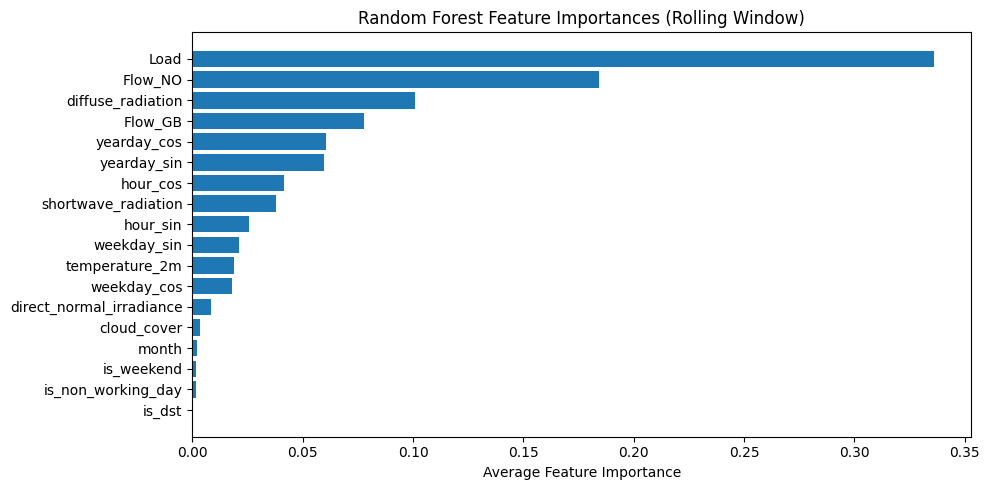

In [159]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Collect feature importances from each run
feature_importances = []
feature_names = TRAIN_FEATURES

for i in range(30):
    start = pd.Timestamp(base_start) + pd.Timedelta(days=i)
    end = pd.Timestamp(base_end) + pd.Timedelta(days=i)
    run_date = pd.Timestamp(base_run) + pd.Timedelta(days=i)

    try:
        df = build_training_set(
            train_start=start.strftime("%Y-%m-%d %H:%M:%S"),
            train_end=end.strftime("%Y-%m-%d %H:%M:%S"),
            run_date=run_date.strftime("%Y-%m-%d %H:%M:%S")
        )
        if df is None or df.empty:
            continue
        df['target_datetime'] = pd.to_datetime(df['target_datetime'], utc=True)
        df = df.sort_values('target_datetime').set_index('target_datetime')
        run_date_utc = run_date.tz_localize("UTC")
        train_data = df[df.index <= run_date_utc]
        test_data = df[df.index > run_date_utc]
        train_data = train_data.dropna(subset=TRAIN_FEATURES + [target])
        if test_data.empty or train_data.empty:
            continue
        X_train = train_data[TRAIN_FEATURES]
        y_train = train_data[target]
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        feature_importances.append(model.feature_importances_)
    except Exception:
        continue

# Calculate mean importances
if feature_importances:
    importances_mean = np.mean(feature_importances, axis=0)
    feat_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances_mean
    }).sort_values(by='Importance', ascending=False)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
    plt.xlabel("Average Feature Importance")
    plt.title("Random Forest Feature Importances (Rolling Window)")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("No feature importances collected.")

2025-05-28 08:48:38,275 - build_training_set - INFO - 🚀 Start build van trainingset
2025-05-28 08:48:38,278 - build_training_set - INFO - 🧠 Actuals van 2025-01-01 00:00:00+00:00 t/m 2025-03-14 23:00:00+00:00
2025-05-28 08:48:38,280 - build_training_set - INFO - 📅 Forecast van run_date 2025-03-15 00:00:00+00:00, target range: 2025-03-15 00:00:00+00:00 → 2025-03-21 23:00:00+00:00
2025-05-28 08:48:38,360 - build_training_set - INFO - ✅ Actuals geladen: 1752 rijen
2025-05-28 08:48:38,673 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=

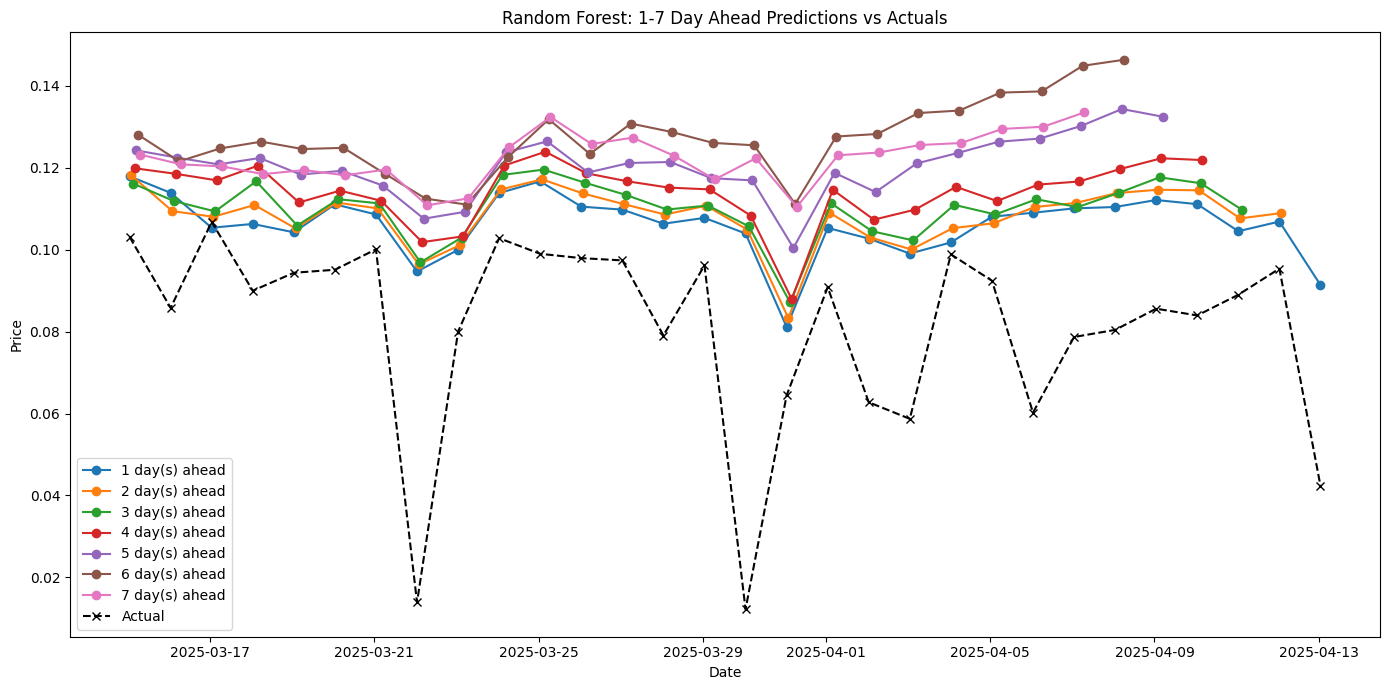

In [142]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Store predictions, actuals, and dates for each run
horizon_preds = {}  # key: horizon (days ahead), value: DataFrame with index=date, columns=['prediction']
actuals = {}

n_horizons = 7  # 7-day ahead forecasts

for horizon in range(1, n_horizons + 1):
    preds = []
    dates = []
    acts = []
    for i in range(30 - horizon + 1):  # ensure enough data for each horizon
        start = pd.Timestamp(base_start) + pd.Timedelta(days=i)
        end = pd.Timestamp(base_end) + pd.Timedelta(days=i)
        run_date = pd.Timestamp(base_run) + pd.Timedelta(days=i)

        try:
            df = build_training_set(
                train_start=start.strftime("%Y-%m-%d %H:%M:%S"),
                train_end=end.strftime("%Y-%m-%d %H:%M:%S"),
                run_date=run_date.strftime("%Y-%m-%d %H:%M:%S")
            )
            if df is None or df.empty:
                continue
            df['target_datetime'] = pd.to_datetime(df['target_datetime'], utc=True)
            df = df.sort_values('target_datetime').set_index('target_datetime')
            run_date_utc = run_date.tz_localize("UTC")
            train_data = df[df.index <= run_date_utc]
            test_data = df[df.index > run_date_utc]
            train_data = train_data.dropna(subset=TRAIN_FEATURES + [target])
            if test_data.empty or train_data.empty:
                continue
            X_train = train_data[TRAIN_FEATURES]
            y_train = train_data[target]
            X_test = test_data[TRAIN_FEATURES]
            y_test = test_data[target]
            model = RandomForestRegressor(n_estimators=100, random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            # For this horizon, pick the prediction for the (horizon-1)th row (if exists)
            if len(y_pred) >= horizon:
                pred_date = X_test.index[horizon-1]
                preds.append(y_pred[horizon-1])
                acts.append(y_test.iloc[horizon-1])
                dates.append(pred_date)
        except Exception:
            continue
    horizon_preds[horizon] = pd.Series(preds, index=dates)
    if horizon == 1:
        actuals = pd.Series(acts, index=dates)

# Plot: for each horizon, plot the predictions for each date
plt.figure(figsize=(14, 7))
for horizon in range(1, n_horizons + 1):
    s = horizon_preds[horizon].sort_index()
    plt.plot(s.index, s.values, marker='o', label=f'{horizon} day(s) ahead')
# Plot actuals
actuals = actuals.sort_index()
plt.plot(actuals.index, actuals.values, color='black', marker='x', linestyle='--', label='Actual')
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Random Forest: 1-7 Day Ahead Predictions vs Actuals")
plt.legend()
plt.tight_layout()
plt.show()

In [162]:
# Optimizing the code for feature selection with Random Forest
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import sys
from pathlib import Path
from sklearn.model_selection import GridSearchCV

# Find project root dynamically
current_dir = Path.cwd()
while current_dir.name != "ENEXIS" and current_dir.parent != current_dir:
    current_dir = current_dir.parent
project_root = current_dir

# Add utils to path
utils_path = project_root / "src" / "utils"
sys.path.append(str(utils_path))
from build_training_set import build_training_set

# Define feature columns and target
COMMON_FEATURES = ['is_dst', 'hour_cos', 'hour_sin', 'month', 'is_non_working_day', 'shortwave_radiation', 'temperature_2m']
TRAIN_ONLY_FEATURES = ['Load', 'Flow_NO']  # <- Only used if known ex post

TRAIN_FEATURES = COMMON_FEATURES + TRAIN_ONLY_FEATURES
TEST_FEATURES = COMMON_FEATURES

target = 'Price'

# Initial training window
base_start = "2025-01-01 00:00:00"
base_end = "2025-03-14 23:00:00"
base_run = "2025-03-15 00:00:00"

rmse_results = []

print("🔍 Testing Random Forest Model - RMSE per forecast day")
print("=" * 60)

# GridSearch parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, None],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Loop over forecast days
for i in range(30):
    start = pd.Timestamp(base_start) + pd.Timedelta(days=i)
    end = pd.Timestamp(base_end) + pd.Timedelta(days=i)
    run_date = pd.Timestamp(base_run) + pd.Timedelta(days=i)

    try:
        df = build_training_set(
            train_start=start.strftime("%Y-%m-%d %H:%M:%S"),
            train_end=end.strftime("%Y-%m-%d %H:%M:%S"),
            run_date=run_date.strftime("%Y-%m-%d %H:%M:%S")
        )

        if df is None or df.empty:
            print(f"Day {i+1}: ❌ No training data returned")
            continue

        df['target_datetime'] = pd.to_datetime(df['target_datetime'], utc=True)
        df = df.sort_values('target_datetime').set_index('target_datetime')

        # Ensure run_date is in UTC
        run_date_utc = run_date.tz_localize("UTC")

        # Split into training and testing sets
        train_data = df[df.index <= run_date_utc]
        test_data = df[df.index > run_date_utc]

        # Drop any missing data in training
        train_data = train_data.dropna(subset=TRAIN_FEATURES + [target])

        if test_data.empty or train_data.empty:
            print(f"Day {i+1}: ❌ Not enough data for training or testing")
            continue

        # Train model
        X_train = train_data[TRAIN_FEATURES]
        y_train = train_data[target]

        # Fill missing columns in test_data with NaN if needed
        for col in TRAIN_FEATURES:
            if col not in test_data.columns:
                test_data[col] = np.nan

        X_test = test_data[TRAIN_FEATURES]
        y_test = test_data[target]

        base_model = RandomForestRegressor(random_state=42)
        grid_search = GridSearchCV(
            estimator=base_model,
            param_grid=param_grid,
            scoring='neg_root_mean_squared_error',
            cv=3,
            n_jobs=-1,
            verbose=0
        )
        grid_search.fit(X_train, y_train)
        print(f"Day {i+1}: 🧪 Best params: {grid_search.best_params_}")
        model = grid_search.best_estimator_

        y_pred = model.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_results.append({
            'iteration': i + 1,
            'run_date': run_date.strftime('%Y-%m-%d'),
            'valid_predictions': len(test_data),
            'rmse': rmse
        })

        print(f"Day {i+1}: ✅ {len(test_data)} test rows, Run: {run_date.strftime('%m-%d')}")

    except Exception as e:
        print(f"Day {i+1}: ❌ Error: {e}")

# Create results dataframe
if rmse_results:
    rmse_df = pd.DataFrame(rmse_results)

    print(f"\n📊 OVERALL RMSE - Random Forest Model")
    print("=" * 80)
    print(f"Successful runs: {len(rmse_df)}/30")

    print(rmse_df[['iteration', 'run_date', 'valid_predictions', 'rmse']].round(2).to_string(index=False))

    print(f"\n📈 SUMMARY STATISTICS")
    print("-" * 40)
    print(rmse_df['rmse'].describe().round(2))

    print(f"\n📊 AVERAGE OVERALL RMSE")
    print("-" * 40)
    print(f"Mean RMSE: {rmse_df['rmse'].mean():.2f}")
else:
    print("❌ No runs completed successfully")

2025-05-30 08:13:48,318 - build_training_set - INFO - 🚀 Start build van trainingset
2025-05-30 08:13:48,321 - build_training_set - INFO - 🧠 Actuals van 2025-01-01 00:00:00+00:00 t/m 2025-03-14 23:00:00+00:00
2025-05-30 08:13:48,323 - build_training_set - INFO - 📅 Forecast van run_date 2025-03-15 00:00:00+00:00, target range: 2025-03-15 00:00:00+00:00 → 2025-03-21 23:00:00+00:00
2025-05-30 08:13:48,444 - build_training_set - INFO - ✅ Actuals geladen: 1752 rijen


🔍 Testing Random Forest Model - RMSE per forecast day


2025-05-30 08:13:48,809 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:13:48,838 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:13:48,838 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 1: 🧪 Best params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Day 1: ✅ 167 test rows, Run: 03-15


2025-05-30 08:14:18,020 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:14:18,040 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:14:18,041 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 2: 🧪 Best params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Day 2: ✅ 167 test rows, Run: 03-16


2025-05-30 08:14:26,794 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:14:26,814 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:14:26,815 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 3: 🧪 Best params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Day 3: ✅ 167 test rows, Run: 03-17


2025-05-30 08:14:37,948 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:14:37,976 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:14:37,976 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 4: 🧪 Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Day 4: ✅ 167 test rows, Run: 03-18


2025-05-30 08:14:47,534 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:14:47,572 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:14:47,573 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 5: 🧪 Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Day 5: ✅ 167 test rows, Run: 03-19


2025-05-30 08:14:57,132 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:14:57,167 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:14:57,168 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 6: 🧪 Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Day 6: ✅ 167 test rows, Run: 03-20


2025-05-30 08:15:08,273 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:15:08,289 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:15:08,291 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 7: 🧪 Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Day 7: ✅ 167 test rows, Run: 03-21


2025-05-30 08:15:20,404 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:15:20,444 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:15:20,446 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 8: 🧪 Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Day 8: ✅ 167 test rows, Run: 03-22


2025-05-30 08:15:30,926 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:15:30,958 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:15:30,960 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 9: 🧪 Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Day 9: ✅ 167 test rows, Run: 03-23


2025-05-30 08:15:44,540 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:15:44,557 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:15:44,558 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 10: 🧪 Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Day 10: ✅ 167 test rows, Run: 03-24


2025-05-30 08:15:54,412 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:15:54,435 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:15:54,435 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 11: 🧪 Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Day 11: ✅ 167 test rows, Run: 03-25


2025-05-30 08:16:04,198 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:16:04,217 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:16:04,227 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 12: 🧪 Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Day 12: ✅ 167 test rows, Run: 03-26


2025-05-30 08:16:13,875 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:16:13,905 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:16:13,909 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 13: 🧪 Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Day 13: ✅ 167 test rows, Run: 03-27


2025-05-30 08:16:28,294 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:16:28,328 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:16:28,329 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 14: 🧪 Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Day 14: ✅ 167 test rows, Run: 03-28


2025-05-30 08:16:39,997 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-30 08:16:40,017 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-30 08:16:40,020 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

KeyboardInterrupt: 